## What is inside

Objective

Gathering Data

Prepare Data for Modeling
    - Supervised/Unsupervised/Regression/Classfication
    - Data Visualization
    - Data Cleaning: Missing Values, Outlier Removal
    - Feature Extraction: Interaction, Lagging, One-Hot Encoding
    - Feature Selection: Univariate/Recursive
    - Split data into train/test
    - Under Sampling, Over Sampling
    - Scaling, Normalizing, outlier removal
Baseline Modeling
    - Select model
        - Linear Regression, Logistic Regression
        - K-nearest neighbors, Decision Tree
        - Support Vector Machine, Random Forest
    - Parameteric Models: Multicolinearity, Relation with the outcome
    - Evaluation Metric: ROC AUC, PR AUC, Accuracy, R2, MSE, RMSE, RSS, MAE
    - Fit model on train-set
    - Test model on test-set
    - Feature importances, ANOVA table(stats_models), Coefficents

Secondary Modeling
    - Reduce Overfitting
        - Hyperparameter Tuning: L1, L2 penality
    - Gradient Boosting, XGBoost, Custom Ensembles
    - Improve generalization error


In [1]:
import pandas as pd
import pickle
from geopy.distance import great_circle
import operator
from scipy import sparse
from scipy.sparse import csr_matrix, vstack, hstack, coo_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

## 1. Objective

Predict whether a restaurant will be closed or not based on its geographical location and user reviews. Most businesses don't just open and close in short period of time. They stay for years before closing. The newest Yelp Dataset was released before 6 months. It contains data about businesses that were opened and closed since 2004. Thus, it will be useful to predict whether a restaurant will close in the next few years. Banks can use this model to make informed loan decisions. Because loans are mostly long-term. Investors want to put their money on a restaurant that is likely to remain for many years.

I searched for related works that try to predict restaurants closure, The project I am aiming to develop is unique in the following aspects:

* It can better generalize across cities because it is trained on 11 meteropolitan areas. The related projects were focused on one city.

* It aims at improving perfomance by combining bag of words with other features, like the surrounding performance. Researchers at Univeristy of Maryland worked on the textual features only and Michail Alifierakis used features related to the surrounding performance only. He didn't encoporate textual features. 

* It uses the most recent version of the dataset which was released before 6 months.

## 2. Gathering Data

http://us-city.census.okfn.org/dataset/food-safety

This dataset is a subset of Yelp's businesses, reviews, and user data. In total, there are :

- 5,200,000 user reviews
- Information on 174,000 businesses
- The data spans 11 metropolitan areas in 4 countries

It is a huge dataset. I beleive that more data contributes in imporivng model generalization.Loading the data to memory at once is impossible. I considered the following options

* a machine learning library other than pandas
* dividing the data into chunks and working one chunk at a time
* database
* cloud

Pandas can read in chunks.I utilized Google Cloud Platform to create a virtual machine with 8 CPUs and 56 GB RAM. The project involved trying models on sets of features, grid search acorss pipelines and processing textual data. The cloud compute engine really helped me see results quickly. 

In [2]:
b = pd.read_json("yelp_academic_dataset_business.json", lines=True)

### Business

Contains business data including location data, attributes, and categories. 

In [3]:
b.head(6)

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
0,1314 44 Avenue NE,"{'BikeParking': 'False', 'BusinessAcceptsCredi...",Apn5Q_b6Nz61Tq4XzPdf9A,"Tours, Breweries, Pizza, Restaurants, Food, Ho...",Calgary,"{'Monday': '8:30-17:0', 'Tuesday': '11:0-21:0'...",1,51.091813,-114.031675,Minhas Micro Brewery,,T2E 6L6,24,4.0,AB
1,,"{'Alcohol': 'none', 'BikeParking': 'False', 'B...",AjEbIBw6ZFfln7ePHha9PA,"Chicken Wings, Burgers, Caterers, Street Vendo...",Henderson,"{'Friday': '17:0-23:0', 'Saturday': '17:0-23:0...",0,35.960734,-114.939821,CK'S BBQ & Catering,,89002,3,4.5,NV
2,1335 rue Beaubien E,"{'Alcohol': 'beer_and_wine', 'Ambience': '{'ro...",O8S5hYJ1SMc8fA4QBtVujA,"Breakfast & Brunch, Restaurants, French, Sandw...",Montréal,"{'Monday': '10:0-22:0', 'Tuesday': '10:0-22:0'...",0,45.540503,-73.599300,La Bastringue,Rosemont-La Petite-Patrie,H2G 1K7,5,4.0,QC
3,211 W Monroe St,None,bFzdJJ3wp3PZssNEsyU23g,"Insurance, Financial Services",Phoenix,None,1,33.449999,-112.076979,Geico Insurance,,85003,8,1.5,AZ
4,2005 Alyth Place SE,{'BusinessAcceptsCreditCards': 'True'},8USyCYqpScwiNEb58Bt6CA,"Home & Garden, Nurseries & Gardening, Shopping...",Calgary,"{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...",1,51.035591,-114.027366,Action Engine,,T2H 0N5,4,2.0,AB
5,"20235 N Cave Creek Rd, Ste 1115","{'BikeParking': 'True', 'BusinessAcceptsCredit...",45bWSZtniwPRiqlivpS8Og,"Coffee & Tea, Food",Phoenix,"{'Monday': '5:30-20:0', 'Tuesday': '5:30-20:0'...",1,33.671375,-112.030017,The Coffee Bean & Tea Leaf,,85024,63,4.0,AZ


See Categories more closely

In [4]:
b.categories.sample(5)

51323     Nightlife, Beer, Wine & Spirits, American (Tra...
39199                                     Restaurants, Thai
70486     Reflexology, Massage, Health & Medical, Beauty...
141433                              Day Spas, Beauty & Spas
10448                                  Burgers, Restaurants
Name: categories, dtype: object

The Yelp Category List

- Active Life
- Arts & Entertainment
- Automotive
- Beauty & Spas
- Education
- Event Planning & Services
- Financial Services
- Food
- Health & Medical
- Home Services
- Hotels & Travel
- Local Flavor
- Local Services
- Mass Media
- Nightlife
- Pets
- Professional Services
- Public Services & Government
- Real estate
- Religious Organizations
- Restaurants
- Shopping

*Each one of these contain other specific categories*

Restaurants
- Afghan
- African
    - Senegalese
    - South African
- American (New)
- American (Traditional)
- Arabian
- Argentine
- Armenian

Attributes are stored as a nested JSON object.

In [5]:
b.attributes[1005]

{'BikeParking': 'True',
 'BusinessAcceptsCreditCards': 'True',
 'BusinessParking': "{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}",
 'ByAppointmentOnly': 'True',
 'GoodForKids': 'True',
 'HairSpecializesIn': "{'coloring': True, 'africanamerican': False, 'curly': True, 'perms': True, 'kids': True, 'extensions': True, 'asian': False, 'straightperms': True}",
 'RestaurantsPriceRange2': '2',
 'WheelchairAccessible': 'True'}

In [6]:
b.columns

Index(['address', 'attributes', 'business_id', 'categories', 'city', 'hours',
       'is_open', 'latitude', 'longitude', 'name', 'neighborhood',
       'postal_code', 'review_count', 'stars', 'state'],
      dtype='object')

All the attributes are displayed as follows. Star rating average of all stars recieved by the business, rounded to half-stars. 

<img src="https://drive.google.com/uc?export=view&id=1-tIQSbZZmff7eQn6p9hqB68BQLOIBw2q" width="500"/>

### Check in

Checkins on a business.

In [7]:
csize = 1e2
checkin_reader = pd.read_json("yelp_academic_dataset_checkin.json", lines=True, chunksize=csize)
for i, ch in enumerate(checkin_reader):
    if(i > 0):
        break

In [8]:
ch.columns

Index(['business_id', 'time'], dtype='object')

In [9]:
ch.head()

,business_id,time
100,6FkCrxJMq5KIgavHRqtlbQ,"{'Tue-4': 1, 'Wed-14': 2, 'Thu-15': 1, 'Sun-16..."
101,d24LIT55-aAr7l1X99vpjw,"{'Fri-1': 1, 'Fri-17': 1, 'Mon-19': 1, 'Tue-22..."
102,2pmOI_mrn1ZWB88IeiOMkA,"{'Tue-16': 1, 'Tue-17': 1, 'Wed-17': 1, 'Wed-2..."
103,KvUuXo2Fpt-rcWR13iLWHg,"{'Wed-0': 1, 'Sun-1': 1, 'Sat-13': 1, 'Mon-16'..."
104,quYlYKkiZ5qRLdu-_hew7g,"{'Tue-17': 1, 'Sun-19': 1}"


### Review

Contains full review text data including the user_id that wrote the review and the business_id the review is written for.

The reviews data is more than 5 GB, uploading it directly took time. I decided to upload the data to an ftp server and transfer it from there. Python has a builtin libraries: ftplib and requests, which can read data from ftp server.

In [10]:
# # import neccessary libraries
# from ftplib import FTP
# import requests

# # login to ftp server
# server = "##.##.###.##"
# username = "******@tinsaealemayehu.com"
# password = "********"
# ftp = FTP(server)
# ftp.login(user=username, passwd=password)

# trans
# rvfile = open("yelp_academic_dataset_review.json", "wb")
# ftp.retrbinary('RETR yelp_academic_dataset_review.json', rvfile.write)
# rvfile.close()

In [11]:
csize = 1e2
review_reader = pd.read_json("yelp_academic_dataset_review.json", lines=True, chunksize=csize)
for i, r in enumerate(review_reader):
    if(i > 0):
        break

In [12]:
r.columns

Index(['business_id', 'cool', 'date', 'funny', 'review_id', 'stars', 'text',
       'useful', 'user_id'],
      dtype='object')

In [13]:
r.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
100,7wHLFohwCw8l6WS-feLjeg,1,2017-04-05,0,5k9F53Lanw09xR3nwCdRYg,5,I had an amazing time here. They were very bus...,1,Yy_iGXxLpL6tYDQoE-6XVg
101,ixAh9crILnJ9tM8LhWFhkw,0,2017-04-05,0,Fv1cqziL1JShSztJWYkTcA,4,I've been coming here for a while and I love h...,0,Yy_iGXxLpL6tYDQoE-6XVg
102,aQ222ydz_GSRZV66xNt4kQ,0,2017-04-09,1,AxhxGl41DItKjqkzYtr53Q,1,2 of my girlfriends recommended this place so ...,1,Yy_iGXxLpL6tYDQoE-6XVg
103,owLBKLyHe85xPba24bmZRw,0,2016-01-23,0,lAyATpsxALW9owlSKhSozA,5,Vickie makes me feel so comfortable every time...,0,Yy_iGXxLpL6tYDQoE-6XVg
104,s3i73_ttk_F33AEdqMr18g,0,2017-01-31,0,_qIXejLYgWGYYtcGcMw1eg,3,The halo-halo was good! I got the mango toast ...,0,Yy_iGXxLpL6tYDQoE-6XVg


See the text, stars, date and user. A review can receive votes from other users: useful, cool, funny. The business that is reviewed, the user who reviewed are linked by business_id and review_id respectively.

<img src="https://drive.google.com/uc?export=view&id=1FD3GDVCTS5ZTj_ohu2p83FJb46hIblEN" width="400"/>

#### Tip

Tips written by a user on a business. Tips are shorter than reviews and tend to convey quick suggestions.

In [14]:
csize=1e2
tip_reader = pd.read_json("yelp_academic_dataset_tip.json", lines=True, chunksize=csize)
for i, t in enumerate(tip_reader):
    if(i > 0):
        break

In [15]:
t.columns

Index(['business_id', 'date', 'likes', 'text', 'user_id'], dtype='object')

In [16]:
t.head()

,business_id,date,likes,text,user_id
100,-InU2nAbC9AuS-Um2Cowgw,2014-03-31,0,Order extra gravy. Its the best thing ever!,QGgWWhEi5R4SLAKN-xwtNQ
101,SurnOSM2bVVN4-Js3G23RQ,2016-04-18,0,"Get the ice tea with raspberries, they add the...",QGgWWhEi5R4SLAKN-xwtNQ
102,ydhgMcBh4A_eihzEAg9LLQ,2015-08-09,0,Still delicious!,QGgWWhEi5R4SLAKN-xwtNQ
103,3CBLxydJU6CFRMGhu9b-sw,2015-11-18,0,Tuesday Special - 50¢ wings,QGgWWhEi5R4SLAKN-xwtNQ
104,Ue4wtaeyhPKvdkXlULimCw,2015-08-26,0,"Add an ice tea for lunch, it's the real thing ...",QGgWWhEi5R4SLAKN-xwtNQ


#### User

User data including the user's friend mapping and all the metadata associated with the user.

In [17]:
# user_reader = pd.read_json("yelp-dataset/yelp_academic_dataset_user.json", lines=True, chunksize=csize)
# csize=1e2
# for i, u in enumerate(user_reader):
#     if(i > 0):
#         break

In [18]:
# u.columns

In [19]:
# u.head()

<img src="https://drive.google.com/uc?export=view&id=1pmFWXvpQjqsrbNqIiSG_DP8B1SSu-z2A" width="500"/>

useful, funny, cool exisit in user table. They refer to number of votes sent by the user. On review table these features were counting number of votes given to a review.

Users can recieve compliments from other users. A complement is given on the profile page. It is not given for a single review, rather on the overall activity of a user. 

Compliment Type | Profile
- | - 
<img src="https://drive.google.com/uc?export=view&id=1yjTX0vvW1vCQClX4Byqfz6OcGBL8ILmu" width="300"/>|<img src="https://drive.google.com/uc?export=view&id=1bzdwJf7tmzlQndbfnv9ORbaCeyX8e300" width="150"/>

## Prepare Data for Modeling

In [20]:
# the code below is just practice code

# from scipy.sparse import csr_matrix, vstack, hstack, coo_matrix
# from IPython.display import HTML, display
# import tabulate

# list1 = np.array([[1,0,0], [4,5,0]])
# list1 = [[1,0,0], [4,5,0]]
# matrix1 = csr_matrix(list1)
# display(HTML(tabulate.tabulate(list1, tablefmt='html')))
# print(matrix1)
# print()
# # stacking a new row
# matrix2 = vstack((matrix1, [0,9,0]))
# list2 = matrix2.toarray()
# display(HTML(tabulate.tabulate(list2, tablefmt='html')))
# print(matrix2)
# print()
# # stacking a new column on matrix1
# matrix3 = hstack((matrix1,[[0],[4.5]] ))
# list3 = matrix3.toarray()
# display(HTML(tabulate.tabulate(list3, tablefmt='html')))
# print(matrix3)
# print()
# # stacking a two columns on matrix1
# matrix4 = hstack((matrix1,[[0,9.9589],[4.5214, 0]] ))
# list4 = matrix4.toarray()
# display(HTML(tabulate.tabulate(list4, tablefmt='html')))
# print(matrix4)
# print()
# # rounding numpy matrices
# matrix4.data= np.round(matrix4.data,2)
# print(matrix4)

### Do closed businesses have more nulls?

In [21]:
# nulls in percent
((b.isnull().sum()/len(b)) * 100).round(5)

address          0.00000
attributes      13.67283
business_id      0.00000
categories       0.28686
city             0.00000
hours           23.75592
is_open          0.00000
latitude         0.00318
longitude        0.00318
name             0.00000
neighborhood     0.00000
postal_code      0.00000
review_count     0.00000
stars            0.00000
state            0.00000
dtype: float64

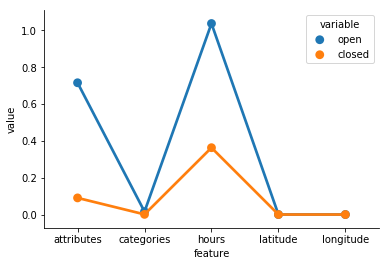

In [22]:
nulls_count = pd.DataFrame({"open":(b[b.is_open == True].isnull().sum()/len(b[b.is_open == False])).round(5), 
                           "closed":(b[b.is_open == False].isnull().sum()/len(b[b.is_open == False])).round(5)})

nulls_count = nulls_count[(nulls_count.open > 0) | (nulls_count.closed > 0)]
nulls_count["feature"] = nulls_count.index
nulls_count_melted = pd.melt(nulls_count, id_vars=['feature'], value_vars=['open', 'closed'])
sns.pointplot(x="feature", y="value", hue="variable", kind="point", data=nulls_count_melted)
sns.despine()
plt.show()

No, closed business have much lesser nulls

### Class imbalance: Business

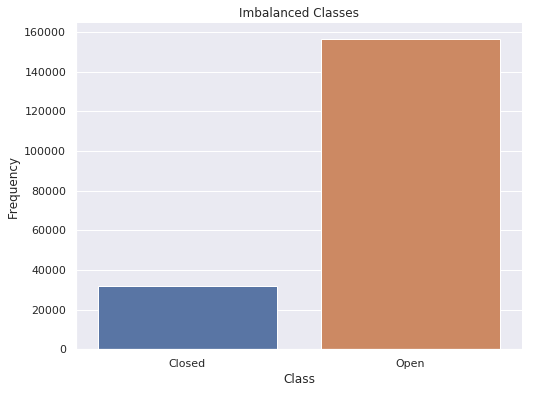

In [23]:
sns.set(rc={'figure.figsize':(8,6)})
sns.countplot(b.is_open)
plt.title("Imbalanced Classes")
plt.xticks([0,1], ("Closed", "Open"))
plt.xlabel("Class")
plt.ylabel("Frequency")
sns.despine()
plt.show()

In [24]:
pd.value_counts(b.is_open)/b.shape[0]

1    0.830391
0    0.169609
Name: is_open, dtype: float64

* 23% of hours is missing. I can drop hours

* 0.29 % rows have missing category. I can drop those rows

* 0.001 % rows have missing latitude, longitude information. Dropping them will not affect the data

* I am not going to use the attributes feature. 

In [25]:
b.drop("hours", axis=1, inplace=True)
b = b.drop(b[b.categories.isnull()].index)
b = b.drop(b[(b.latitude.isnull()) | (b.longitude.isnull()) ].index)
b = b.drop("attributes", axis=1)
# nulls in percent
((b.isnull().sum()/len(b)) * 100).round(5)

address         0.0
business_id     0.0
categories      0.0
city            0.0
is_open         0.0
latitude        0.0
longitude       0.0
name            0.0
neighborhood    0.0
postal_code     0.0
review_count    0.0
stars           0.0
state           0.0
dtype: float64

### Binarize Categories

A business is labeled to more than one categories. Converting them to binary will make filtering and analyzing very easy. Let me try to one-hot encode them.  

In [26]:
b.categories.head()

0    Tours, Breweries, Pizza, Restaurants, Food, Ho...
1    Chicken Wings, Burgers, Caterers, Street Vendo...
2    Breakfast & Brunch, Restaurants, French, Sandw...
3                        Insurance, Financial Services
4    Home & Garden, Nurseries & Gardening, Shopping...
Name: categories, dtype: object

Splitting by comma works except for businesses that have a single category seprated by commas. 

- Books, Mags, Music & Video
- Used, Vintage & Consignment
- Beer, Wine & Spirits
- Wills, Trusts, & Probates

Since there is no syntatical difference beween single category containing comma and multiple categories separated by comma, i couln't find a regex expression to deal with this problem. Replacing manually is the remaining option.

In [27]:
b.loc[:, 'categories'] = b.categories.str.replace("Books, Mags, Music & Video", "Books+Mags+ & MusicVideo")
b.loc[:, 'categories'] = b.categories.str.replace("Used, Vintage & Consignment", "Used+Vintage+ & Consignment")
b.loc[:, 'categories'] = b.categories.str.replace("Beer, Wine & Spirits", "Beer+Wine & Spirits")
b.loc[:, 'categories'] = b.categories.str.replace("Wills, Trusts, & Probates", "Wills+Trusts+&Probates")

One hot encoding is for single label categorical variables. For multiple labels Scikit-learn's MultiLabelBinarizer is the way to go. 

In [28]:
# split by comma
categories_series = b.categories.apply(lambda x: x.split(","))
# a  lambda function to convert the following data structure
# [list(['Tours', ' Breweries', ' Pizza', ' Restaurants', ' Food', ' Hotels & Travel'])
# to 
# ['Tours', ' Breweries', ' Pizza', ' Restaurants', ' Food', ' Hotels & Travel']
take_out_list = lambda x: list(x)
# get 2D list
categories_2D_list = take_out_list(categories_series)
# remove leading and trailing white spaces
for alist in categories_2D_list:
    alist[:] = [category.strip() for category in alist]
#print(categories_2D_list[:3])
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
categories_binarized = mlb.fit_transform(categories_2D_list)
#print(categories_binarized.shape)
#print(mlb.classes_.shape)
# mlb.classes_ returns the unique categories found by the binarizer
categories_binarized_df = pd.DataFrame(categories_binarized, columns=list(mlb.classes_))
categories_binarized_df.sample(10)

,3D Printing,ATV Rentals/Tours,Acai Bowls,Accessories,Accountants,Acne Treatment,Active Life,Acupuncture,Addiction Medicine,Adoption Services,...,Wine Tasting Room,Wine Tours,Wineries,Women's Clothing,Workers Compensation Law,Wraps,Yelp Events,Yoga,Ziplining,Zoos
40016,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
51375,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
126224,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4554,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41540,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
164340,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33586,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40225,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23310,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
67731,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
mlb.classes_

array(['3D Printing', 'ATV Rentals/Tours', 'Acai Bowls', ..., 'Yoga',
       'Ziplining', 'Zoos'], dtype=object)

### Top 20 Business Categories

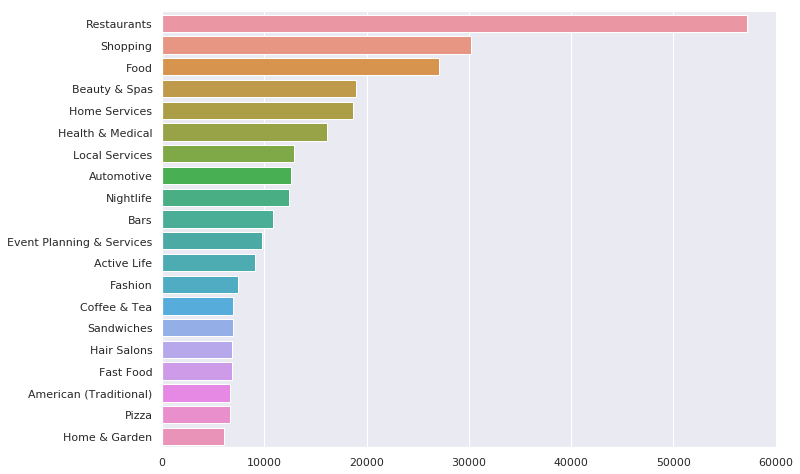

In [30]:
top_20_categories = categories_binarized_df.sum().sort_values(ascending=False)[:20]
sns.set(rc={'figure.figsize':(11,8)})
ax = sns.barplot(y=top_20_categories.index, x=top_20_categories.values, orient='h')
sns.despine()

### Are these categories combined in groups of 3 or more?

In [31]:
# find the number of total busineses
total_business = categories_binarized_df.shape[0]
combinations_of_top20 = categories_binarized_df[top_20_categories.index].apply(lambda x: list(x.index[np.where(x != 0)]), axis=1)
# convert index to string to make it hashable
import json
# dumps converts list to string
combinations_of_top20 = combinations_of_top20.map(json.dumps)
value_counts_top20 = combinations_of_top20.value_counts()
value_counts_top20
count_g_2 = 0
for c in value_counts_top20.index:
    # count combinations of two or more categories
    # loads converts back to list
    if(len(json.loads(c)) > 2):
        count_g_2 += value_counts_top20.loc[c]
print(count_g_2)
print(np.round((count_g_2/total_business) * 100, 2), "%")

26718
14.21 %


Only 14% of all businesses have combined categories from the top-20 categories. This indicates that most of these are top level categories encompassing many businesses.

In [32]:
total_business

188045

There are 1888045 businesses in the dataset.

### Which of these top business categories have higher closure?

In [33]:
top_20_categories.index

Index(['Restaurants', 'Shopping', 'Food', 'Beauty & Spas', 'Home Services',
       'Health & Medical', 'Local Services', 'Automotive', 'Nightlife', 'Bars',
       'Event Planning & Services', 'Active Life', 'Fashion', 'Coffee & Tea',
       'Sandwiches', 'Hair Salons', 'Fast Food', 'American (Traditional)',
       'Pizza', 'Home & Garden'],
      dtype='object')

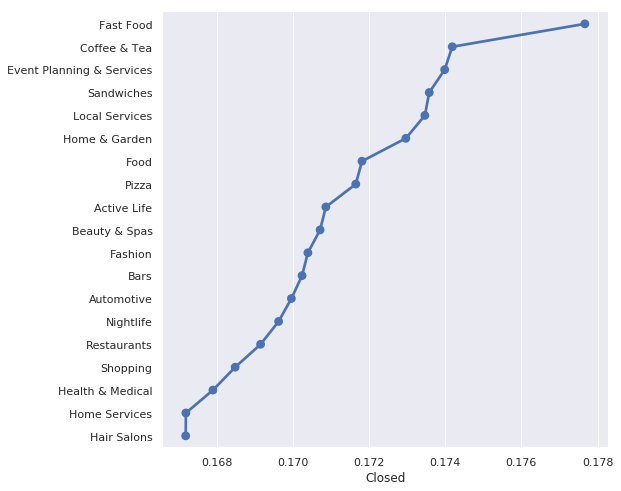

In [34]:
# concatenate is_open info to the binaried categories data
open_close_df = pd.concat([categories_binarized_df[top_20_categories.index], b.is_open], axis=1)
# find all open businesses
open_df = open_close_df[open_close_df.is_open ==1]
# find all closed businesses
close_df = open_close_df[open_close_df.is_open ==0]
# sum across columns to find number of open business in each column(category)
open_close_count = (pd.concat([open_df.sum(), close_df.sum()], axis=1))
# change the default column names
open_close_count.columns = ["Open", "Closed"]
#print(open_close_count)
# divide the counts by the total businesses in each category
open_close_count_normalized = open_close_count.div(open_df.sum() + close_df.sum(), axis=0).sort_values(by="Closed", ascending=False)[:-2]
sns.set(rc={'figure.figsize':(8,8)})
ax = sns.pointplot(x=open_close_count_normalized.Closed, y=open_close_count_normalized.index, orient='h')
sns.despine()

Those businesses that are at the end of the top 20 list are on the top on this graph and vice versa. Fast-food and Coffee/Tea have the highest closure rate though they are limited in number compared to the other businesses. Shopping centers and Health and Medical businesses are in large quantities but they are least likely to be closed.

### Number of Reviews: Restaurants vs Shopping

In [35]:
categories_binarized_df["business_id"] = b.business_id.values
categories_binarized_df["is_open"] = b.is_open.values

restaurants_df =  categories_binarized_df[categories_binarized_df.Restaurants == 1]
shopping_df = categories_binarized_df[categories_binarized_df.Shopping == 1]

total_reviews = 5996996

# # the code below takes time. The results are saved to file and loaded in the next cell

# csize = 1e6
# review_reader = pd.read_json("yelp_academic_dataset_review.json", lines=True, chunksize=csize)


# num_restaurant_reviews = 0
# num_shopping_reviews = 0
# total_reviews = 0 
# for i, r in enumerate(review_reader):
#     total_reviews += r.shape[0]
#     print("working on chunk ",i," shape =", r.shape[0])
#     # count number of restaurant reviews found in chunk r
#     num_restaurant_reviews += pd.merge(restaurants_df, r, on=["business_id"]).shape[0]
#     # count number of shopping reviews found in chunk r
#     num_shopping_reviews += pd.merge(shopping_df, r, on=["business_id"]).shape[0]

    
# pickle.dump(num_restaurant_reviews, open("yelp-dataset/num_restaurant_reviews.sav", 'wb'))
# pickle.dump(num_shopping_reviews,open("yelp-dataset/num_shopping_reviews.sav", 'wb'))

In [36]:
num_restaurant_reviews = pickle.load(open("yelp-dataset/num_restaurant_reviews.sav", 'rb'))
num_shopping_reviews = pickle.load(open("yelp-dataset/num_shopping_reviews.sav", 'rb'))

print("Percent of Restaurant Businesses: {:.2f}".format(restaurants_df.shape[0] / total_business))
print("Percent of Shopping Businesses: {:.2f}".format(shopping_df.shape[0] / total_business))
print()
print("Percent of Restaurant Reviews: {:.2f}".format(num_restaurant_reviews / total_reviews))
print("Percent of Shopping Reviews: {:.2f}".format(num_shopping_reviews / total_reviews))

Percent of Restaurant Businesses: 0.30
Percent of Shopping Businesses: 0.16

Percent of Restaurant Reviews: 0.61
Percent of Shopping Reviews: 0.07


There are a lot of restaurants on Yelp. Second top are shopping businesses. When you see the number of reviews restaurants take more share than their number. Thus, restaurants are highly reviewed.

### Reviews by Year

In [37]:
#The following code takes time. Saved data is loaded in the next cell

# csize=1e6
# review_reader = pd.read_json("yelp_academic_dataset_review.json", lines=True, chunksize=csize)
# total_reviews = 0 
# restaurant_open_review_years = []
# restaurant_closed_review_years = []
# shopping_open_review_years = []
# shopping_closed_review_years = []

# for i, r in enumerate(review_reader):
#     total_reviews += r.shape[0]
#     print("working on chunk ",i," shape =", r.shape[0])
    
#     restaurant_reviewsR = pd.merge(restaurants_df, r, on=["business_id"])
    
#     restaurant_reviews_closed = restaurant_reviewsR[restaurant_reviewsR.is_open == 0]
#     restaurant_reviews_open = restaurant_reviewsR[restaurant_reviewsR.is_open == 1]
    
    
#     restaurant_closed_review_years.append(pd.to_datetime(restaurant_reviews_closed.date.dt.year).values)
#     restaurant_open_review_years.append(pd.to_datetime(restaurant_reviews_open.date.dt.year).values)
 
#     shopping_restaurantR= pd.merge(shopping_df, r, on=["business_id"])
    
#     shopping_reviews_closed = shopping_restaurantR[shopping_restaurantR.is_open == 0]
#     shopping_reviews_open = shopping_restaurantR[shopping_restaurantR.is_open == 1]
    
#     shopping_closed_review_years.append(pd.to_datetime(shopping_reviews_closed.date.dt.year).values)
#     shopping_open_review_years.append(pd.to_datetime(shopping_reviews_open.date.dt.year).values)
    
# # save the lists to file
# pickle.dump(restaurant_open_review_years, open("yelp-dataset/restaurant_open_review_years.sav", 'wb'))
# pickle.dump(restaurant_closed_review_years, open("yelp-dataset/restaurant_closed_review_years.sav", 'wb'))
# pickle.dump(shopping_open_review_years, open("yelp-dataset/shopping_open_review_years.sav",'wb'))
# pickle.dump(shopping_closed_review_years, open("yelp-dataset/shopping_closed_review_years.sav", 'wb'))

In [38]:
# load lists from file
restaurant_open_review_years = pickle.load(open("yelp-dataset/restaurant_open_review_years.sav", 'rb'))
restaurant_closed_review_years = pickle.load(open("yelp-dataset/restaurant_closed_review_years.sav", 'rb'))
shopping_open_review_years = pickle.load(open("yelp-dataset/shopping_open_review_years.sav", 'rb'))
shopping_closed_review_years = pickle.load(open("yelp-dataset/shopping_closed_review_years.sav", 'rb'))

restaurant_open_review_years = np.concatenate(restaurant_open_review_years).ravel()
restaurant_closed_review_years = np.concatenate(restaurant_closed_review_years).ravel()
shopping_open_review_years = np.concatenate(shopping_open_review_years).ravel()
shopping_closed_review_years = np.concatenate(shopping_closed_review_years).ravel()

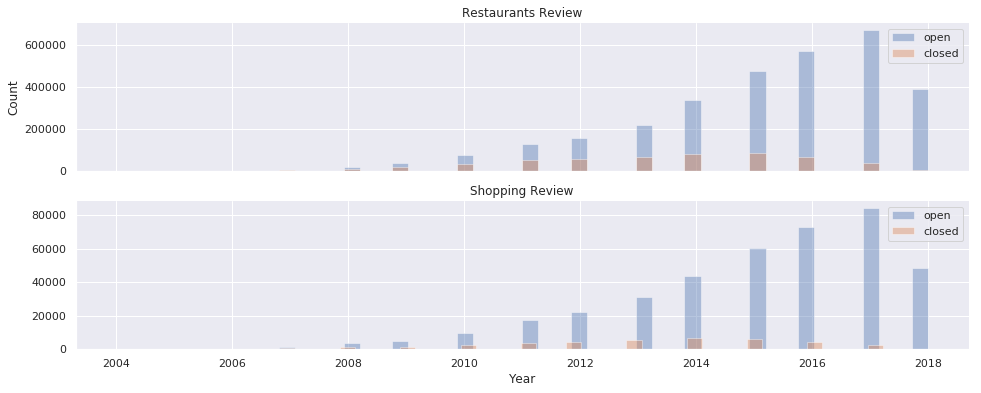

In [39]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(16,6), sharex= True, sharey=False)

sns.set(rc={'figure.figsize':(4,4)})
sns.distplot(restaurant_open_review_years.astype(int), kde=False, label="open", ax=ax1)
sns.distplot(restaurant_closed_review_years.astype(int), kde=False, label = "closed", ax=ax1)
ax1.legend()
ax1.set_ylabel("Count")
ax2.set_xlabel("Year")
ax1.set_title("Restaurants Review")

sns.distplot(shopping_open_review_years.astype(int), kde=False, label="open", ax=ax2)
sns.distplot(shopping_closed_review_years.astype(int), kde=False, label = "closed", ax=ax2)
ax2.set_title("Shopping Review")
ax2.set_xlabel("Year")
ax1.set_ylabel("Count")
sns.despine()
ax2.legend()
plt.show()

The information on when a restaurant is closed is not provided by Yelp. We can only approximate the rate of closure based on the distrubiton of reviews. The graph shows that restaurants started recieving reviews on Yelp since 2004 and the reviews continued to increase. The year 2017 is the peak year for open restaurants. Many restaurants that were reviewed in 2014/15 are closed. We can not be sure whether they were closed in the same year or later.

Many shopping businesses that were reviewed in 2014-15 are closed by now.

### Approxmating Restaurants Age

In [40]:
#The following code takes 15 minutes. Saved data is loaded in the next cell

# csize = 1e5
# review_reader = pd.read_json("yelp_academic_dataset_review.json", lines=True, chunksize=csize)
# total_reviews = 0 
# #restaurant_open_last_review_year = []
# #hopping_open_last_review_year = 
# #hopping_closed_last_review_year = []
# for i, r in enumerate(review_reader):
#     with warnings.catch_warnings():
#         warnings.simplefilter("ignore")
#         print("working on chunk ",i," shape =", r.shape[0])

#         restaurant_reviewsR = pd.merge(restaurants_df, r, on=["business_id"])

#         restaurant_reviewsR["review_year"] = pd.to_datetime(restaurant_reviewsR.date.dt.year)

#         if(i == 0):
#             restaurants_open_year = restaurant_reviewsR[["business_id", "review_year"]].groupby("business_id")["review_year"].min()
#             restaurants_closed_year = restaurant_reviewsR[["business_id", "review_year"]].groupby("business_id")["review_year"].max()

#         else:
#             restaurants_open_year = pd.concat([restaurants_open_year, restaurant_reviewsR[["business_id", "review_year"]].groupby("business_id")["review_year"].min()])
#             restaurants_closed_year = pd.concat([restaurants_closed_year, restaurant_reviewsR[["business_id", "review_year"]].groupby("business_id")["review_year"].max()])

# # save the dataframes to file
# pickle.dump(restaurants_open_year, open("yelp-dataset/restaurants_open_year.sav", 'wb'))
# pickle.dump(restaurants_closed_year, open("yelp-dataset/restaurants_closed_year.sav", 'wb'))

In [41]:
# open and close in the file names refer to earliest review year and most recent review years
# it is a naming mistake made when dumping the objects
earliest_review_year_all = pickle.load(open("yelp-dataset/restaurants_open_year.sav", 'rb'))
most_recent_review_year_all = pickle.load(open("yelp-dataset/restaurants_closed_year.sav", 'rb'))

earliest_review_year = earliest_review_year_all.groupby("business_id").min()
most_recent_review_year = most_recent_review_year_all.groupby("business_id").max()

restaurants_dates = pd.concat([earliest_review_year, most_recent_review_year], axis=1)
restaurants_dates.columns = ["earliest_review_year", "most_recent_review_year"]
# filter required attributes
restaurants_only = pd.merge(b[["business_id", "latitude", "longitude", "stars","review_count", "is_open"]], 
                            restaurants_dates, on="business_id")
restaurants_only.head()

,business_id,latitude,longitude,stars,review_count,is_open,earliest_review_year,most_recent_review_year
0,Apn5Q_b6Nz61Tq4XzPdf9A,51.091813,-114.031675,4.0,24,1,1970-01-01 00:00:00.000002013,1970-01-01 00:00:00.000002018
1,AjEbIBw6ZFfln7ePHha9PA,35.960734,-114.939821,4.5,3,0,1970-01-01 00:00:00.000002017,1970-01-01 00:00:00.000002017
2,O8S5hYJ1SMc8fA4QBtVujA,45.540503,-73.599300,4.0,5,0,1970-01-01 00:00:00.000002014,1970-01-01 00:00:00.000002016
3,6OuOZAok8ikONMS_T3EzXg,43.712946,-79.632763,2.0,7,1,1970-01-01 00:00:00.000002012,1970-01-01 00:00:00.000002014
4,8-NRKkPY1UiFXW20WXKiXg,33.448106,-112.341302,2.5,40,1,1970-01-01 00:00:00.000002008,1970-01-01 00:00:00.000002018


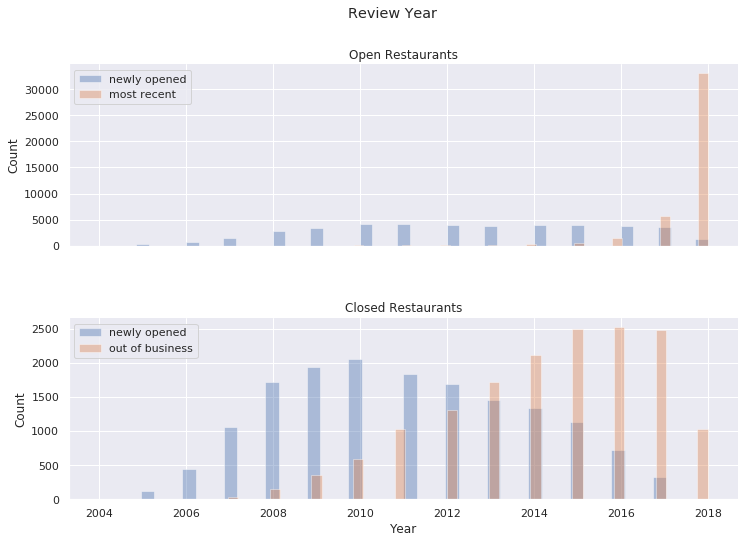

In [42]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(12,8), sharex=True)
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)

sns.set(rc={'figure.figsize':(4,4)})

open_earliest_years = restaurants_only[restaurants_only.is_open == True].earliest_review_year.values.astype(int)
open_most_recent_years = restaurants_only[restaurants_only.is_open == True].most_recent_review_year.values.astype(int)
closed_earliest_years = restaurants_only[restaurants_only.is_open == False].earliest_review_year.values.astype(int)
closed_most_recent_years = restaurants_only[restaurants_only.is_open == False].most_recent_review_year.values.astype(int)


sns.distplot(open_earliest_years, kde=False, label="newly opened", ax=ax1)
sns.distplot(open_most_recent_years, kde=False, label = "most recent", ax=ax1)

sns.distplot(closed_earliest_years, kde=False, label="newly opened", ax=ax2)
sns.distplot(closed_most_recent_years, kde=False, label = "out of business", ax=ax2)

ax1.set_title("Open Restaurants")
ax2.set_title("Closed Restaurants")

ax1.legend(loc="upper left")
ax2.legend(loc="upper left")
ax1.set_ylabel("Count")
ax2.set_ylabel("Count")

ax2.set_xlabel("Year")
plt.suptitle("Review Year")
sns.despine()

We are approximating the earliest year as the opening year of a restaurant. For currently closed restaurants, the most recent year is approximated as the out of business year.

Looking at the upper graph; almost all currently open restaurants were reviewed within the last 2 years. The distriubtion of earliest review year is left skewed. Since 2010 similar number of restaurants were opened

Looking at the bottom graph; number of newly opened restaurants is normally distributed for closed restaurants. Many restaurants that were opened in 2010 are closed by now. Restaurants that are recently opened are not closed by now. This indicates that new restaurants are not very likely to be closed and it takes some years. The difference betwen number new restaurants(red) and closed restaurants(blue) kept on increasing until 2013 and then it decreases.

They are many contributing factors that are outside the scope of this analysis.

In [43]:
len(set(restaurants_only.business_id))

57173

There are 57173 restaurants on Yelp

### Create Age Feature

In [44]:
# subtract earliest review year from 2018
restaurants_only["age"] = 2018 - restaurants_only.earliest_review_year.values.astype(int)
# select features
restaurants_only = restaurants_only[['business_id', 'latitude', 'longitude', 'stars', 'review_count','age', 'is_open']]
restaurants_only.age.describe()

count    57173.000000
mean         5.993266
std          3.145764
min          0.000000
25%          3.000000
50%          6.000000
75%          8.000000
max         14.000000
Name: age, dtype: float64

The maximum age is only 14 years because Yelp started in 2004

### Class Imbalance: Restaurants

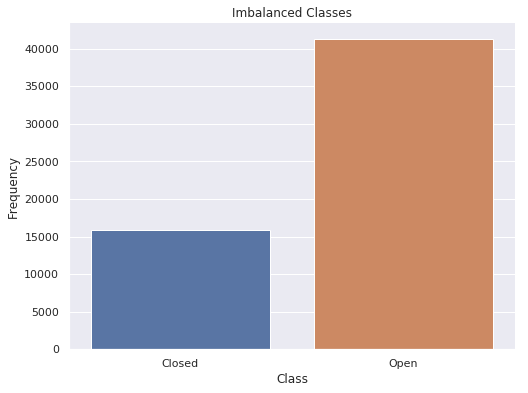

In [45]:
sns.set(rc={'figure.figsize':(8,6)})
sns.countplot(restaurants_only.is_open)
plt.title("Imbalanced Classes")
plt.xticks([0,1], ("Closed", "Open"))
plt.xlabel("Class")
plt.ylabel("Frequency")
sns.despine()
plt.show()

In [46]:
pd.value_counts(restaurants_only.is_open)/restaurants_only.shape[0]

1    0.723104
0    0.276896
Name: is_open, dtype: float64

Open and Closed Restaurants are not as imbalanced as they are for all busineses. Out of all businesses 83% of them are open but among all restaurants 72% of them are open.

In [47]:
restaurants_only.head()

,business_id,latitude,longitude,stars,review_count,age,is_open
0,Apn5Q_b6Nz61Tq4XzPdf9A,51.091813,-114.031675,4.0,24,5,1
1,AjEbIBw6ZFfln7ePHha9PA,35.960734,-114.939821,4.5,3,1,0
2,O8S5hYJ1SMc8fA4QBtVujA,45.540503,-73.599300,4.0,5,4,0
3,6OuOZAok8ikONMS_T3EzXg,43.712946,-79.632763,2.0,7,6,1
4,8-NRKkPY1UiFXW20WXKiXg,33.448106,-112.341302,2.5,40,10,1


### Outliers

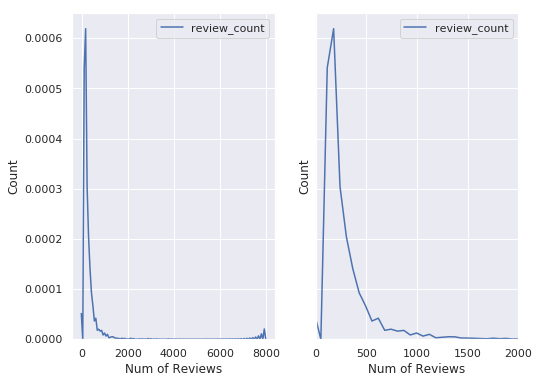

In [48]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,6), sharey=True)
# making spaces between subplots
#fig.subplots_adjust(hspace = 0.2, wspace = 0.2)
ax1.set_xlabel("Num of Reviews")
ax2.set_xlabel("Num of Reviews")
ax1.set_ylabel("Count")
ax2.set_ylabel("Count")
sns.kdeplot(restaurants_only.review_count.sort_values(), ax=ax1)
sns.kdeplot(restaurants_only.review_count.sort_values(), ax=ax2)
ax2.set_xlim(0, 2000)
plt.show()

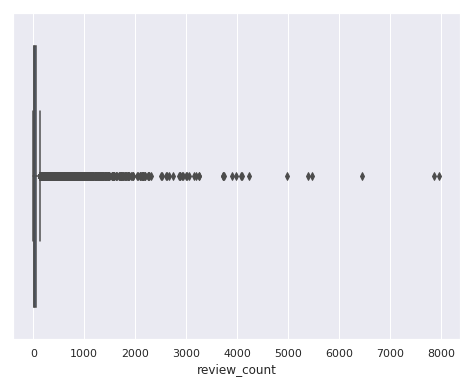

In [49]:
sns.boxplot(restaurants_only.review_count.sort_values())
plt.show()

In [50]:
from scipy import stats
z = np.abs(stats.zscore(restaurants_only.review_count))
threshold = 3
outlier_businesses = list(np.where(z > 3)[0])
print("Number of restaurants: ", restaurants_only.shape[0])
print("Number of outliers: ", len(outlier_businesses))

Number of restaurants:  57173
Number of outliers:  786


Removing 786 businesses will not harm because there is plenty of data.

In [51]:
business_ids = restaurants_only.iloc[outlier_businesses, 0].to_frame()
pd.merge(business_ids, b, on=["business_id"])[["name", "state", "review_count", "address"]].sample(10)

,name,state,review_count,address
183,Marché Bacchus,NV,682,"2620 Regatta Dr, Ste 106"
318,La Grande Orange Pizzeria,AZ,785,4410 N 40th St
638,Hussong's Cantina Las Vegas,NV,692,"3930 S Las Vegas Blvd, Ste 121B"
462,The Coffee Cup,NV,576,512 Nevada Hwy
546,Olives,NV,1768,3600 S Las Vegas Blvd
375,North Italia,AZ,658,"North Arcadia, 4925 N 40th St"
196,The Westin Las Vegas Hotel & Spa,NV,626,160 East Flamingo Rd
263,Palace Station Hotel & Casino,NV,719,2411 W Sahara Ave
354,Angels Trumpet Ale House,AZ,1023,810 N 2nd St
521,Egg Works,NV,920,6960 S Rainbow Blvd


These must be very popular places because they are highly reviewed. They may create problems during text processing because a lot of words will be used in their reviews. 

In [52]:
# check shape of dataframe before removal
restaurants_only.shape

(57173, 7)

In [53]:
# remove outlier businesses
restaurants_only = restaurants_only.drop(outlier_businesses)

In [54]:
# check shape again
restaurants_only.shape

(56387, 7)

In [55]:
# !python -m spacy download en
# import nltk
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')

## Working on Yelp Reviews Data

In [56]:
# import spacy
# nlp = spacy.load("en", disable=['parser', 'ner'])
# doc = nlp("She was dancing and walking in the garden. Flowers and plants are refreshing. I have a flower factory")
# for token in doc:
#     print(token.lemma_)

In [57]:
# using spacy lemmatizer as a class
#from spacy.lemmatizer import Lemmatizer
#from spacy.lang.en import LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES
#lemmatizer = Lemmatizer(LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES)
#print(nltk.pos_tag(["traumatizing"]))
#print(lemmatizer("hers", "P"))

# nltk classes used for tokenization and lemmatization
#from nltk import word_tokenize
#from nltk.stem import WordNetLemmatizer 

### Custom Tokenizer-Lemmatizer

Scikit-learn's vectorizers don't convert words into their base form by default. The custom lemmatizer/tokenizer is passed as tokenizer for CountVectorizer and TfIdfVectorizer Objects.

I tried to use NLTK's word_tokenize and WordNetLemmatizer. NLTK methods work on a specified part of speech, the default is noun. It is not flexible to work for multiple part of speech. 

Spacy is very flexible. When a spacy object is created, it will automatically know the part of speech of all tokens in the given document. It converts words into their base form depending on their POS tag. The only problem with spacy is its speed. Creating a spacy document involves tagging, parsing and named entity recognition. I disabled the steps that I don't need which increased its speed.

In [58]:
import spacy
nlp = spacy.load("en", disable=['parser', 'ner'])
# Use custom tokenizer and lemmatizer
def lemmatizer_tokenize(a_review):
    # remove extra space and new line
    a_review = ' '.join(a_review.split())
    a_review = nlp(a_review)
    words = [token.lemma_ for token in a_review
                if (
                    not token.is_digit and
                    not token.is_punct and 
                    not token.is_stop and 
                    token.lemma_ != "-PRON-"
                )
            ]
    return words

In [59]:
# testing lemmatizer
lemmatizer_tokenize("Dancing entertains people. The girl was dancing when the shooters entered the club")

['dancing',
 'entertain',
 'people',
 'the',
 'girl',
 'dance',
 'shooter',
 'enter',
 'club']

The first "Dancing" is  a noun. The second "dancing" is a verb. Spacy only converted the verb to its base form. Shooters is a noun, converted to shooter. "Entered" is a verb, converted to enter.

In [60]:
restaurants_only.head()

,business_id,latitude,longitude,stars,review_count,age,is_open
0,Apn5Q_b6Nz61Tq4XzPdf9A,51.091813,-114.031675,4.0,24,5,1
1,AjEbIBw6ZFfln7ePHha9PA,35.960734,-114.939821,4.5,3,1,0
2,O8S5hYJ1SMc8fA4QBtVujA,45.540503,-73.599300,4.0,5,4,0
3,6OuOZAok8ikONMS_T3EzXg,43.712946,-79.632763,2.0,7,6,1
4,8-NRKkPY1UiFXW20WXKiXg,33.448106,-112.341302,2.5,40,10,1


In [61]:
# #tokenizer pattern and replace practice
# myvect1 = CountVectorizer(stop_words = 'english')
# myvect2 = CountVectorizer(stop_words = 'english')

# somelist = pd.Series(["Tinse is great ጥሩ ˈdäNG person", "Ethiopia is my country!", "15Brown fox", "Quick", "13 it is nice"])
# somelist2 = pd.Series(["Tinse is great ጥሩ",  "däNG person", "fox"])

# somelist = somelist.str.replace(r'(?u)[^\w\s]+|[\d]+', '')
# somelist2 = somelist2.str.replace(r'(?u)[^\w\s]+|[\d]+', '')
# #print(somelist)
# transformed1 = myvect1.fit(somelist)
# transformed2 = myvect2.fit(somelist2)

# #print(myvect.vocabulary_)
# myvect1.get_feature_names()
# myvect2.get_feature_names()
# the_vocabulary = set(sorted(myvect1.get_feature_names() + myvect2.get_feature_names()))
# myvectx = TfidfVectorizer(vocabulary=the_vocabulary)
# myvectx.vocabulary
# sparse.csr_matrix([1,2,3,0])

### 1. Simple TF-IDF Features

#### Train/Test Split

In [125]:
X = restaurants_only.drop("is_open", axis=1)
# # change is_open to is_closed
y = np.where(restaurants_only["is_open"] == 0 , 1, 0)
# stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20, shuffle=True, stratify=y)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
# combine x and y to ease feature engineering
# shallow copy
train = X_train.copy(deep=True)
train["is_closed"] = y_train
test = X_test.copy(deep=True)
# shallow copy
test["is_closed"] = y_test
print(train.shape)
train.head()

(45109, 7)


,business_id,latitude,longitude,stars,review_count,age,is_closed
0,rGJt5LSMUuaMufNuXcyb_A,43.678838,-79.720137,3.0,17,9,0
1,G5gkRgTMqN0iIpyoW6oTYg,43.657790,-79.487801,3.5,9,3,1
2,Qg4Ou9YwqXf10zxQGrw0sA,43.774523,-79.177464,3.5,11,6,1
3,soqpbgQt0v4BrEOwV03FkQ,33.334549,-111.804860,3.5,22,7,1
4,UPoM5nmUiklwqBV5pLuK7Q,33.421371,-111.893141,3.5,6,11,0


### Train-set

In [126]:
# #Takes a lot of time. Saved models are loaded in the next cells
# import time
# from sklearn.feature_extraction.text import TfidfVectorizer
# csize=1e6
# start_time = time.time()
# review_reader = pd.read_json("yelp_academic_dataset_review.json", lines=True, chunksize=csize)
# from scipy import sparse
# for i, r in enumerate(review_reader):
#     # work on chunk2 only to save time
#     if(i < 2):
#         continue
#     if(i > 2):
#         break
#     print("working on chunk ",i," shape =", r.shape[0])
#     tfidf_train_reviews = pd.merge(train, r, on=["business_id"])
#     # save dense matrix to file
#     tfidf_train_reviews.to_csv("yelp-dataset/tfidf_train_reviews"+ str(i) + ".csv")
#     # tokens containing numbers, digits and underscore are ignored
#     tfidf_vectorizer_train = TfidfVectorizer(stop_words='english', min_df=0.001, tokenizer=lemmatizer_tokenize)  
#     # remove punctuation and numbers
#     tfidf_train_reviews.text = tfidf_train_reviews.text.str.replace(r'[^\w\s]+|[\d]+', '')
#     tfidf_features_train = tfidf_vectorizer_train.fit_transform(tfidf_train_reviews.text)
#     # save vectorizer
#     pickle.dump(tfidf_vectorizer_train, open("yelp-dataset/tfidf_vectorizer_train"+ str(i) +".sav", 'wb'))
        
#     # save sparse matrix to file
#     sparse.save_npz("yelp-dataset/tfidf_features_train"+ str(i) + ".npz", tfidf_features_train)
   
#     print("shape of dense matrix: ", tfidf_train_reviews.shape)
#     print("shape of sparse matrix:(tfidf) ", tfidf_train_reviews.shape)
# print(time.time() - start_time)

working on chunk  2  shape = 1000000
shape of dense matrix:  (380760, 15)
shape of sparse matrix:(tfidf)  (380760, 15)
2013.4731860160828


#### Load the Vectors

In [157]:
i = 2
tfidf_features_train = sparse.load_npz("yelp-dataset/tfidf_features_train" + str(i) + ".npz")
tfidf_vectorizer_train = pickle.load(open("yelp-dataset/tfidf_vectorizer_train"+ str(i) + ".sav", 'rb'))
tfidf_train_reviews = pd.read_csv("yelp-dataset/tfidf_train_reviews" + str(i) + ".csv", index_col=0)
# get the indices of reviews for each business id
reviews_indices_dict_tfidf_train = tfidf_train_reviews.business_id.groupby(tfidf_train_reviews.business_id).groups

#### Average Words Per Business

In [158]:
import time
start_time = time.time()
num_of_sparse_features = len(tfidf_vectorizer_train.vocabulary_)
# k goes over the business ids
# i counts
the_sparse_matrices_tf_idf_train = []

for i, k in enumerate(reviews_indices_dict_tfidf_train.keys()):
    if( i % 10000 == 0):
        print("creating row: ", i)
    # convert to list: row indices for the reviews of k
    indices_for_sparse_matrix = list(reviews_indices_dict_tfidf_train[k])
    # find means column-wise
    means_sparse = tfidf_features_train[indices_for_sparse_matrix, :].mean(axis=0).tolist()[0]
    the_sparse_matrices_tf_idf_train.append(means_sparse)
pickle.dump(the_sparse_matrices_tf_idf_train, open("yelp-dataset/the_sparse_matrices_tf_idf_train.sav", "wb"))    
print(time.time() - start_time)

creating row:  0
creating row:  10000
creating row:  20000
creating row:  30000
35.50138974189758


#### Prepare X and Y

In [159]:
tf_idf_aggregate_train = sparse.csr_matrix(the_sparse_matrices_tf_idf_train)
# selected features
tfidf_train_reviews = tfidf_train_reviews[['business_id', 'stars_x', 'review_count', 'latitude','longitude','age', 'is_closed']]
# remove duplicates
tfidf_train_reviews.drop_duplicates(inplace=True)
# sort by business id
tfidf_train_reviews = tfidf_train_reviews.sort_values(by = "business_id").reset_index(drop=True)
# remove business id and move is_closed to the front
tfidf_train_reviews = tfidf_train_reviews[['is_closed', 'stars_x', 'review_count', 'latitude','longitude','age']]
# merge sparse and dense features
tf_idf_train_final = hstack((tfidf_train_reviews , tf_idf_aggregate_train)).tocsr()
tf_idf_train_final

<37998x3224 sparse matrix of type '<class 'numpy.float64'>'
	with 7496217 stored elements in Compressed Sparse Row format>

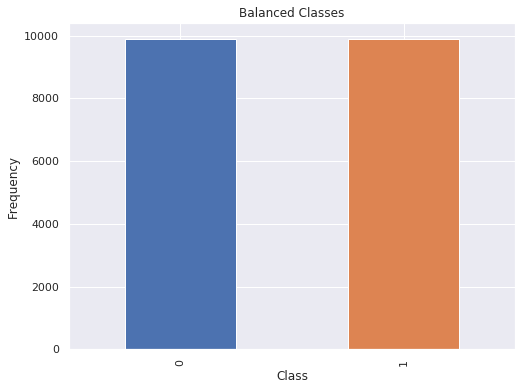

0    9903
1    9903
dtype: int64


In [161]:
X_train = tf_idf_aggregate_train[:,1:]
y_train = tfidf_train_reviews.is_closed

from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_train_tf_idf, y_train_tf_idf = rus.fit_sample(X_train, y_train)
count_classes = pd.value_counts(y_train_tf_idf.flatten(), sort=True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Balanced Classes")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()
print(count_classes)

### Test-set

In [171]:
# #Takes a lot of time. Saved models are loaded in the next cells
# import time
# from sklearn.feature_extraction.text import TfidfVectorizer
# csize=1e6
# start_time = time.time()
# review_reader = pd.read_json("yelp_academic_dataset_review.json", lines=True, chunksize=csize)
# from scipy import sparse
# for i, r in enumerate(review_reader):
#     # work on chunk2 only to save time
#     if(i < 2):
#         continue
#     if(i > 2):
#         break
#     print("working on chunk ",i," shape =", r.shape[0])
#     tfidf_test_reviews = pd.merge(test, r, on=["business_id"])
#     # save dense matrix to file
#     tfidf_test_reviews.to_csv("yelp-dataset/tfidf_test_reviews"+ str(i) + ".csv")
#     # tokens containing numbers, digits and underscore are ignored
#     # remove punctuation and numbers
#     tfidf_test_reviews.text = tfidf_test_reviews.text.str.replace(r'[^\w\s]+|[\d]+', '')
#     # use train vectorizer
#     tfidf_features_test = tfidf_vectorizer_train.transform(tfidf_test_reviews.text)
        
#     # save sparse matrix to file
#     sparse.save_npz("yelp-dataset/tfidf_features_test"+ str(i) + ".npz", tfidf_features_test)
   
#     print("shape of dense matrix: ", tfidf_features_test.shape)
#     print("shape of sparse matrix:(tfidf) ", tfidf_test_reviews.shape)
# print(time.time() - start_time)

#### Load the Vectors

In [172]:
i = 2
tfidf_features_test = sparse.load_npz("yelp-dataset/tfidf_features_test" + str(i) + ".npz")
tfidf_test_reviews = pd.read_csv("yelp-dataset/tfidf_test_reviews" + str(i) + ".csv", index_col=0)
# get the indices of reviews for each business id
reviews_indices_dict_tfidf_test = tfidf_test_reviews.business_id.groupby(tfidf_test_reviews.business_id).groups

#### Average words per Business

In [173]:
import time
start_time = time.time()
num_of_sparse_features = len(tfidf_vectorizer_train.vocabulary_)
# k goes over the business ids
# i counts
the_sparse_matrices_tf_idf_test = []

for i, k in enumerate(reviews_indices_dict_tfidf_test.keys()):
    if( i % 10000 == 0):
        print("creating row: ", i)
    # convert to list: row indices for the reviews of k
    indices_for_sparse_matrix = list(reviews_indices_dict_tfidf_test[k])
    # find means column-wise
    means_sparse = tfidf_features_test[indices_for_sparse_matrix, :].mean(axis=0).tolist()[0]
    the_sparse_matrices_tf_idf_test.append(means_sparse)
pickle.dump(the_sparse_matrices_tf_idf_test, open("yelp-dataset/the_sparse_matrices_tf_idf_test.sav", "wb"))    
print(time.time() - start_time)

creating row:  0
7.791294574737549


#### Prepare X and y

In [174]:
tf_idf_aggregate_test = sparse.csr_matrix(the_sparse_matrices_tf_idf_test)
# selected features
tfidf_test_reviews = tfidf_test_reviews[['business_id', 'stars_x', 'review_count', 'latitude','longitude','age', 'is_closed']]
# remove duplicates
tfidf_test_reviews.drop_duplicates(inplace=True)
# sort by business id
tfidf_test_reviews = tfidf_test_reviews.sort_values(by = "business_id").reset_index(drop=True)
# remove business id and move is_closed to the front
tfidf_test_reviews = tfidf_test_reviews[['is_closed', 'stars_x', 'review_count', 'latitude','longitude','age']]
# merge sparse and dense features
tf_idf_test_final = hstack((tfidf_test_reviews , tf_idf_aggregate_test)).tocsr()
tf_idf_test_final

<9492x3224 sparse matrix of type '<class 'numpy.float64'>'
	with 1879499 stored elements in Compressed Sparse Row format>

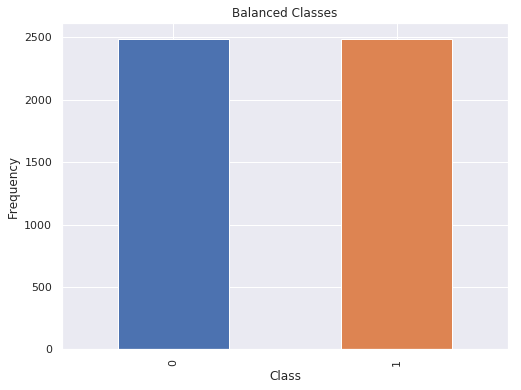

0    2490
1    2490
dtype: int64


In [175]:
X_test = tf_idf_aggregate_test[:,1:]
y_test =  tfidf_test_reviews.is_closed

from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_test_tf_idf, y_test_tf_idf = rus.fit_sample(X_test, y_test)
count_classes = pd.value_counts(y_test_tf_idf.flatten(), sort=True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Balanced Classes")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()
print(count_classes)

### 2. Bag of Words 

In [69]:
# Takes a lot of time(1hour). Saved models are loaded in the next cells
# import time
# from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
# csize=1e6
# start_time = time.time()
# review_reader = pd.read_json("yelp_academic_dataset_review.json", lines=True, chunksize=csize)
# from scipy import sparse
# for i, r in enumerate(review_reader):
#     # work on chunk2 only to save time
#     if(i < 2):
#         continue
#     if(i > 2):
#         break
#     print("working on chunk ",i," shape =", r.shape[0])
#     restaurants_reviews = pd.merge(restaurants_only, r, on=["business_id"])
#     # save dense matrix to file
#     restaurants_reviews.to_csv("yelp-dataset/restaurants_reviews"+ str(i) + ".csv")
#     # tokens containing numbers, digits and underscore are ignored

#     restaurants_vectorizer_bow2 = CountVectorizer(stop_words='english', min_df=0.001, tokenizer=lemmatizer_tokenize) 

#     # remove punctuation and numbers
#     restaurants_reviews.text = restaurants_reviews.text.str.replace(r'[^\w\s]+|[\d]+', '')
    
#     bow_features2 = restaurants_vectorizer_bow2.fit_transform(restaurants_reviews.text)
    
#     # save vectorizer, the vectorizer contains the vocabulary
#     pickle.dump(restaurants_vectorizer_bow2, open("yelp-dataset/restaurants_vectorizer_bow"+ str(i) +".sav", 'wb'))
#     # save sparse matrix to file
#     sparse.save_npz("yelp-dataset/bow_features"+ str(i) + ".npz", bow_features2)
    
#     print("shape of dense matrix: ", restaurants_reviews.shape)
#     print("shape of sparse matrix:(tfidf) ", bow_features2.shape)
# print(time.time() - start_time)

#### Load the Vectors

In [70]:
i = 2
bow_features2 = sparse.load_npz("yelp-dataset/bow_features" + str(i) + ".npz")
restaurants_vectorizer_bow2 = pickle.load(open("yelp-dataset/restaurants_vectorizer_bow"+ str(i) + ".sav", 'rb'))
restaurants_reviews = pd.read_csv("yelp-dataset/restaurants_reviews" + str(i) + ".csv", index_col=0)


# get the indices of reviews for each business id
reviews_indices_dict_bow = restaurants_reviews.business_id.groupby(restaurants_reviews.business_id).groups

print(bow_features2.shape)
print(restaurants_reviews.shape)

(476253, 3213)
(476253, 15)


#### Average Bag of Words Vectors Per Business

In [71]:
import time
#takes 10 minutes
start_time = time.time()
num_of_sparse_features = len(restaurants_vectorizer_bow2.vocabulary_)
# k goes over the business ids
# i counts
the_sparse_matrices_bag = []

# closed restaurants
for i, k in enumerate(reviews_indices_dict_bow.keys()):
    if( i % 10000 == 0):
        print("creating row: ", i)
    # convert to list: row indices for the reviews of k
    indices_for_sparse_matrix = list(reviews_indices_dict_bow[k])
    # find means column-wise
    means_sparse = bow_features2[indices_for_sparse_matrix, :].mean(axis=0).tolist()[0]
    the_sparse_matrices_bag.append(means_sparse)
# save aggregate sparse matrix
pickle.dump(the_sparse_matrices_bag, open("yelp-dataset/the_sparse_matrices_bag.sav", "wb"))    
print(time.time() - start_time)

creating row:  0
creating row:  10000
creating row:  20000
creating row:  30000
creating row:  40000
47.049424171447754


#### Prepare X and Y

In [72]:
restaurants_bow_aggregate = sparse.csr_matrix(the_sparse_matrices_bag)

In [73]:
# selected features
restaurants_reviews = restaurants_reviews[['business_id', 'stars_x', 'review_count', 'latitude','longitude','age', 'is_open']]
# remove duplicates
restaurants_reviews.drop_duplicates(inplace=True)
# sort by business id
restaurants_reviews = restaurants_reviews.sort_values(by = "business_id").reset_index(drop=True)

In [74]:
# change is_open to is_closed
restaurants_reviews["is_closed"] = np.where(restaurants_reviews.is_open == 0 , 1, 0)
restaurants_reviews = restaurants_reviews[['is_closed', 'stars_x', 'review_count', 'latitude','longitude','age']]
# merge sparse and dense features
restaurants_bow_final = hstack((restaurants_reviews , restaurants_bow_aggregate)).tocsr()
restaurants_bow_final

<47490x3219 sparse matrix of type '<class 'numpy.float64'>'
	with 9374200 stored elements in Compressed Sparse Row format>

In [75]:
restaurants_reviews.columns

Index(['is_closed', 'stars_x', 'review_count', 'latitude', 'longitude', 'age'], dtype='object')

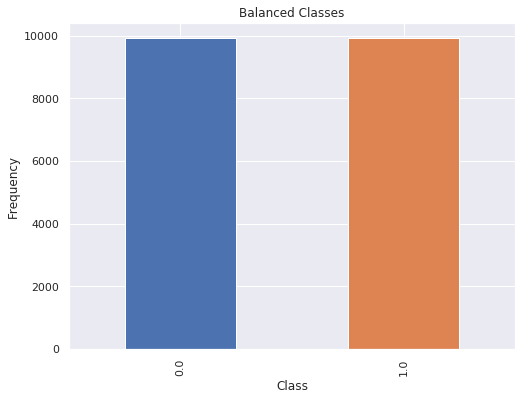

0.0    9914
1.0    9914
dtype: int64


In [76]:
# include the target attribute in X. It will be used for IDF penalty
X = restaurants_tf_idf_final
y = restaurants_tf_idf_final[:,0].toarray()

# stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20, shuffle=True, stratify=y)

from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0)
X_train_bow, y_train_bow = rus.fit_sample(X_train, y_train)
X_test_bow, y_test_bow = rus.fit_sample(X_test, y_test)

count_classes = pd.value_counts(y_train_bow.flatten(), sort=True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Balanced Classes")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()
print(count_classes)

### 3. Bag of Words Penalized by IDF

In [78]:
from sklearn.base import BaseEstimator, TransformerMixin

class IDFPenalty(BaseEstimator, TransformerMixin):
    def transform(self, X, *_):
        self.X = X
        # indices of open restaurants
        open_rest_indices = np.where(X[:, 0].toarray() == 0)[0]
        # indices of closed restauratns
        closed_rest_indices = np.where(X[:, 0].toarray() == 1)[0]
        num_of_open_restaurants = len(open_rest_indices)
        num_of_closed_restaurants = len(closed_rest_indices)
        
        # textual features start from index 6
        idf_open = np.log10(num_of_open_restaurants / (1 + np.array(self.X[open_rest_indices, 6:].sum(axis=0).tolist()[0]))).reshape(1,-1)
        idf_closed = np.log10(num_of_closed_restaurants / (1 + np.array(self.X[closed_rest_indices, 6:].sum(axis=0).tolist()[0]))).reshape(1,-1)
        
        self.X[open_rest_indices, 6:] = sparse.csr_matrix(self.X[open_rest_indices, 6:].toarray() * idf_closed)
        self.X[closed_rest_indices, 6:] = sparse.csr_matrix(self.X[closed_rest_indices, 6:].toarray() * idf_open)
        # remove is_closed column and return
        return self.X[:, 1:]
    
    def fit(self, *_):
        return self

In [81]:
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline

pipeline = Pipeline([('IDF', IDFPenalty()),
                     ("scale", Normalizer())])
#  the target attribute is appended to the front
X_train_bow_penalized = pipeline.fit_transform(X_train_bow)
#  the target attribute is appended to the front
X_test_bow_penalized = pipeline.fit_transform(X_test_bow)
# same target classes: y_train_bow and y_test_bow

## Surrounding Restaurants
Within 1 mile circle, average ratings, average number of reviews

Training data supplied to this transformer will have stars, review_count, latitude, longitude and age. In a pipeline Distance Transformer is the last one. Bag of words features contain the target class. So the a pipeline step should handle it correctly

In [82]:
X_train_bow.shape

(19828, 3219)

These are 3212 textual features and 7 dense featurs

In [83]:
# I can use one of the X_trains for testing surrounding restaurants
print("min latitude", X_train_simple_tf_idf[:,2].min())
print("max latitude", X_train_simple_tf_idf[:,2].max())
print("min longtiude", X_train_simple_tf_idf[:,3].min())
print("max longtiude", X_train_simple_tf_idf[:,3].max())

min latitude -34.8693315397
max latitude 59.438181380799996
min longtiude -122.823161956
max longtiude 115.08676899999999


In [84]:
X_train_sep = pd.DataFrame({'average_stars':X_train_simple_tf_idf[:,0].toarray().flatten(),
                            'review_count':X_train_simple_tf_idf[:,1].toarray().flatten(),
                            'latitude':X_train_simple_tf_idf[:,2].toarray().flatten(),
                            'longitude':X_train_simple_tf_idf[:,3].toarray().flatten()})


X_train_sep.head()

,average_stars,review_count,latitude,longitude
0,4.5,99.0,36.074029,-115.082891
1,4.0,283.0,36.114843,-115.153196
2,3.5,210.0,36.095800,-115.296601
3,4.5,40.0,45.528243,-73.598002
4,4.0,88.0,43.038073,-89.452020


In [85]:
# A vectorized implemenation of geopy.distance.great_circle function
# Adopted by Tinsae 
# reference
# https://gist.github.com/rochacbruno/2883505
    
import math
# calculate the disance between a business and all other businesses
def distance_c(many_points, one_point):
    # convert the values to float
    lat1 = many_points[:,0].astype(float) 
    lon1 = many_points[:,1].astype(float)
    lat2 = one_point[0]
    lon2 = one_point[1]
    #radius = 6371 # km
    radius = 3959 # miles
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat/2) * np.sin(dlat/2) + np.cos(np.radians(lat1)) \
        * np.cos(np.radians(lat2)) * np.sin(dlon/2) * np.sin(dlon/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = radius * c

    return d

# for testing purposes(calculating the distance between buisness@1 and others)
business5 = X_train_sep[['latitude', 'longitude']].values[5:6]
business8 = X_train_sep[['latitude', 'longitude']].values[8:9]
business18 = X_train_sep[['latitude', 'longitude']].values[18:19]
business1 = X_train_sep[['latitude', 'longitude']].values[1]

print("distance from 5: ", great_circle(business5, business1).miles)
print("distance from 8: ", great_circle(business8, business1).miles)
print("distance from 18: ", great_circle(business18, business1).miles)

distance_c(X_train_sep[['latitude', 'longitude']].values[0:20], business1)       

distance from 5:  248.92305625588324
distance from 8:  1446.3304245972151
distance from 18:  271.92541918590587


array([   4.83345217,    0.        ,    8.11320766, 2240.46460503,
       1443.14152269,  248.93805554, 1921.11385748,  241.14924296,
       1446.4175757 ,    5.63989251, 2239.62861175, 1955.4212395 ,
       1815.91569051,   10.79772988, 1918.27471715, 1946.93846548,
       1920.49161551, 1950.18219579,  271.94180452, 2215.58979508])

### Distance Transformer

In [86]:
from sklearn.base import BaseEstimator, TransformerMixin

class DistanceTransformer(BaseEstimator, TransformerMixin):
    def transform(self, X, *_):
        self.nearest_average_rating=[]
        self.nearest_average_num_of_reviews =[]

        self.X = X
        self.X_sep = pd.DataFrame({'average_stars':X[:,0].toarray().flatten(),
                            'review_count':X[:,1].toarray().flatten(),
                            'latitude':X[:,2].toarray().flatten(),
                            'longitude':X[:,3].toarray().flatten()})
        
        self.X_sep.apply(lambda current: self.create_distance_features(current), axis=1)
        nearest_average_rating = np.array(self.nearest_average_rating).reshape(-1,1)
        nearest_average_num_of_reviews = np.array(self.nearest_average_num_of_reviews).reshape(-1,1)

        return sparse.hstack((nearest_average_rating, nearest_average_num_of_reviews, self.X.astype(float)))
    
    # calculate the disance between a business and all other businesses
    def distance_c(self, many_points, one_point):
        # convert the values to float
        lat1 = many_points[:,0].astype(float) 
        lon1 = many_points[:,1].astype(float)
        lat2 = one_point[0]
        lon2 = one_point[1]
        #radius = 6371 # km
        radius = 3959 # miles
        dlat = np.radians(lat2 - lat1)
        dlon = np.radians(lon2 - lon1)
        a = np.sin(dlat/2) * np.sin(dlat/2) + np.cos(np.radians(lat1)) \
            * np.cos(np.radians(lat2)) * np.sin(dlon/2) * np.sin(dlon/2)
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
        d = radius * c
        return d        
    
    def create_distance_features(self, current):
        # find the distance between current row and all other rows using the vectorized function
        the_distances = self.distance_c(self.X_sep[['latitude', 'longitude']].values, (current.latitude, current.longitude))    
        # A distance cannot be negative. 0 indicates it is the same place
        # so both shall be excluded
        indices_to_select = np.where((the_distances < 1) & (the_distances > 0))[0]
        # if a business within one mile is found
        if(len(indices_to_select) > 0):
            self.nearest_average_rating.append(self.X_sep.iloc[indices_to_select, :].average_stars.mean())
            self.nearest_average_num_of_reviews.append(self.X_sep.iloc[indices_to_select, :].review_count.mean())
        else:
            self.nearest_average_rating.append(np.nan)
            self.nearest_average_num_of_reviews.append(np.nan)    
    
    def fit(self, *_):
        return self

### Custom Normalizer

In [87]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import Normalizer, StandardScaler

class CustomNormalizer(BaseEstimator, TransformerMixin):        

    def transform(self, X, *_):
        self.X = X
        # column 4 and 5 are removed(latitude and longitude)
        return sparse.hstack(( StandardScaler().fit_transform(self.X[:, [0,1,2,3,6]].toarray()),  
                              Normalizer().fit_transform(self.X[:, 7:]) ))
    
    def fit(self, *_):
        return self

### Latent Semantic Analysis

In [88]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD

class LSA(BaseEstimator, TransformerMixin):        

    def transform(self, X, *_):
        self.X = X.tocsr()
        svd= TruncatedSVD(1000)
        lsa = make_pipeline(svd, Normalizer(copy=False))
        svd.fit_transform(self.X[:, 5:])
        variance_explained = svd.explained_variance_ratio_
        total_variance = variance_explained.sum()
        print("Percent variance captured by all components:",total_variance*100)

        # reduce tfidf features from 3603 to 500
        return sparse.hstack((self.X[:, 0:5], svd.fit_transform(self.X[:, 5:])))
    
    def fit(self, *_):
        return self

In [89]:
# # test code
# sc = StandardScaler()
# sc.fit_transform(X_train[:,2].toarray())
# X_train[0:5, 0:5].toarray()
# X_train_transformed.tocsr()[0:5, 0:5].toarray()
# CNR = CustomNormalizer()
# X_train_transformed = CNR.transform(X_train)
# (X_train_transformed).tocsr()[0:5, 0:5].toarray()

In [90]:
# this is used for testing the tranformer

# DFC = DistanceFeaturesCreator()
# X_train_transformed = DFC.transform(X_train)
# (X_train_transformed).tocsr()[0:5, 0:5].toarray()


# import time

# nearest_average_rating = []
# nearest_average_num_of_reviews =  []
# start_time = time.time()

# X_train_sep2 = X_train_sep.copy(deep=True)

# def create_distance_features(current):
#     # find the distance between current row and all other rows using the vectorized function
#     the_distances = distance_c(X_train_sep2[['latitude', 'longitude']].values, (current.latitude, current.longitude))    
#     # A distance cannot be negative. 0 indicates it is the same place
#     # so both shall be excluded
#     indices_to_select = np.where((the_distances < 1) & (the_distances > 0))[0]
#     # if a business within one mile is found
#     if(len(indices_to_select) > 0):
#         nearest_average_rating.append(X_train_sep2.iloc[indices_to_select, :].average_stars.mean())
#         nearest_average_num_of_reviews.append(X_train_sep2.iloc[indices_to_select, :].review_count.mean())
#     else:
#         nearest_average_rating.append("No-Nearest")
#         nearest_average_num_of_reviews.append("No-Nearest")

        
# X_train_sep2.apply(lambda x: create_distance_features(x), axis=1)
# print(time.time() - start_time, " seconds")


# X_train_sep2["nearest_average_rating"] = nearest_average_rating
# X_train_sep2["nearest_average_num_of_reviews"] = nearest_average_num_of_reviews
# X_train_sep2.head()

In [91]:
# # This is for testing

# X_train_transformed
# RNN = RemoveNoNearest()

# RNN = RemoveNoNearest()
# X_transformed_again, y_transformed = RNN.transform(X_train_transformed.tocsr(), y_train)

# X_transformed_again = RNN.transform(X_train_transformed.tocsr())
# X_train_transformed
# X_transformed_again
# X_train_transformed.tocsr()[312, 0:2].toarray()
# np.isnan(X_transformed_again.toarray()).sum()

In [92]:
# from sklearn.preprocessing import StandardScaler
# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
#     scaler = StandardScaler()
#     dense_train_sel_sorted[dense_train_sel_sorted.columns.drop("is_closed")] = scaler.fit_transform(dense_train_sel_sorted[dense_train_sel_sorted.columns.drop("is_closed")])
# dense_train_sel_sorted.head(5)

In [ ]:
# create dataframe for plotting purpose
column_headers = ['nearest_average_rating', 'nearest_averge_number_of_reviews','average_stars', 
                  'review_count', 'age_of_restaurant']
df = pd.DataFrame(X_train_rt.tocsr()[:, :5 ].toarray(), columns=column_headers)
df.head()

In [ ]:

# Code from https://seaborn.pydata.org/examples/many_pairwise_correlations.html
sns.set(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
sns.pairplot(df)

## 2. Baseline Modeling

I am using undersampled data to test logistic regression and decsion tree models. Other estimators don't perform good. The pipelines transform train and test set separately. I tried to use three forms of textual features.

* Simple TF-IDF
* Bag of Words
* Bag of Words with IDF Penality

In [94]:
from sklearn.metrics import classification_report, confusion_matrix,roc_auc_score,average_precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer

In [95]:
# these are the first 5 features
first_5 = ["nearest_average_rating", "nearest_averge_number_of_reviews", "average_stars", "review_count", "age_of_restaurant"] 
first_5

['nearest_average_rating',
 'nearest_averge_number_of_reviews',
 'average_stars',
 'review_count',
 'age_of_restaurant']

In [96]:
# these are the remaining
restaurants_vectorizer_bow2.get_feature_names()[:10]

['ability',
 'able',
 'absolute',
 'absolutely',
 'ac',
 'accent',
 'accept',
 'acceptable',
 'access',
 'accessible']

In [97]:
# combine the features
all_the_features =  first_5 + list(restaurants_vectorizer_bow2.get_feature_names())
len(all_the_features)

3218

### A. Simple TF-IDF Model

The preprocessing is done in the previous section in this way. I split the train and test sets before a and converted each of them to tfidf vectors. The same vocabulary is used for both.  Doing a train-test split after tfidf vectorization creates a weak model because test-set data will leak to the train-set. 

In [179]:
pipeline = Pipeline([
                     ('dtf', DistanceTransformer()),
                     ('imputer', SimpleImputer(strategy="mean")), 
                     ("scale-normalize", CustomNormalizer())])
# ("lsa", LSA())

In [180]:
X_train_tf_idf_t = pipeline.fit_transform(X_train_tf_idf)

In [181]:
X_test_tf_idf_t = pipeline.fit_transform(X_test_tf_idf)

#### Logistic Regression

In [185]:
logistic_model = LogisticRegression(penalty='l2', C=1.25)
logistic_model.fit(X_train_tf_idf_t, y_train_tf_idf)
y_pred = logistic_model.predict(X_test_tf_idf_t)
y_pred_train = logistic_model.predict(X_train_tf_idf_t)
print('\n Confusion Matrix')
print(pd.crosstab(y_test_tf_idf, y_pred, rownames=['True'], colnames=['Predicted']))
print(classification_report(y_test_tf_idf, y_pred))
print("ROC-AUC", roc_auc_score(y_test_tf_idf, y_pred))
print("PR-AUC-Score", average_precision_score(y_test_tf_idf, y_pred))
print("Test Accuracy: ", accuracy_score(y_test_tf_idf, y_pred))
print("Train Accuracy: ", accuracy_score(y_train_tf_idf, y_pred_train))


 Confusion Matrix
Predicted     0     1
True                 
0          1772   718
1           781  1709
              precision    recall  f1-score   support

           0       0.69      0.71      0.70      2490
           1       0.70      0.69      0.70      2490

   micro avg       0.70      0.70      0.70      4980
   macro avg       0.70      0.70      0.70      4980
weighted avg       0.70      0.70      0.70      4980

ROC-AUC 0.698995983935743
PR-AUC-Score 0.6401253137808756
Test Accuracy:  0.698995983935743
Train Accuracy:  0.7526002221549025


In [186]:
print("Most positive cofficeints\n(contribute positively to restaurants closure)")
print()
sorted_features = np.argsort(logistic_model.coef_).ravel()[::-1]
for i in range(14):
    print(all_the_features[sorted_features[i]], end=",")
print()
print("\nMost negative cofficeints\n(contribute negatively to restaurants closure)")
print()
sorted_features = np.argsort(logistic_model.coef_).ravel()
for i in range(15):
    print(all_the_features[sorted_features[i]],end=",")

Most positive cofficeints
(contribute positively to restaurants closure)

groupon,veg,si,theme,par,remove,slaw,runny,schnitzel,hop,overwhelming,burst,clearly,clear,

Most negative cofficeints
(contribute negatively to restaurants closure)

bus,route,stool,allow,fave,fashion,substitution,attack,bday,park,management,tropical,limited,yeah,peu,

#### Decision Trees

In [187]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train_simple_tf_idf_t, y_train_simple_tf_idf)
y_pred = dt_model.predict(X_test_simple_tf_idf_t)
print('\n Confusion Matrix')
print(pd.crosstab(y_test_simple_tf_idf, y_pred, rownames=['True'], colnames=['Predicted']))
print(classification_report(y_test_simple_tf_idf, y_pred))
print("ROC-AUC", roc_auc_score(y_test_simple_tf_idf, y_pred))
print("PR-AUC-Score", average_precision_score(y_test_simple_tf_idf, y_pred))
print("Test Accuracy: ", accuracy_score(y_test_simple_tf_idf, y_pred))


 Confusion Matrix
Predicted   0.0   1.0
True                 
0.0        1548   931
1.0         964  1515
              precision    recall  f1-score   support

         0.0       0.62      0.62      0.62      2479
         1.0       0.62      0.61      0.62      2479

   micro avg       0.62      0.62      0.62      4958
   macro avg       0.62      0.62      0.62      4958
weighted avg       0.62      0.62      0.62      4958

ROC-AUC 0.6177894312222671
PR-AUC-Score 0.5729562503277736
Test Accuracy:  0.617789431222267


In [188]:
sorted_features = np.argsort(dt_model.feature_importances_)[::-1]
for i in range(20):
    print(all_the_features[sorted_features[i]], end=",")

nearest_averge_number_of_reviews,review_count,age_of_restaurant,employee,fast,drive,customer,place,location,service,nearest_average_rating,menu,busy,owner,order,try,good,thing,restaurant,nice,

### B. Bag of Words Model

In the preprocessing step, the bag of words vectors were created for all the data. And then the data is split into train and test set. Unlike the tfidf transformation, bag of words vectorization don't leak data. Every business has its own reviews and words are counted based on those reviews. Coupus-wide information like inverse document frequency is not used.

In [189]:
pipeline = Pipeline([
                     ('dtf', DistanceTransformer()),
                     ('imputer', SimpleImputer(strategy="mean")), 
                     ("scale-normalize", CustomNormalizer())])
# ("lsa", LSA())

In [190]:
X_train_bow_t = pipeline.fit_transform(X_train_bow[:, 1:])
X_test_bow_t = pipeline.fit_transform(X_test_bow[:, 1:])

In [191]:
y_train_bow = y_train_bow.ravel()
y_test_bow = y_test_bow.ravel()

#### Logistic Regression

In [266]:
X_train_bow[:, 6].toarray()

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [279]:
logistic_model = LogisticRegression(penalty='l2', C=1.0)
logistic_model.fit(X_train_bow_t, y_train_bow)
y_pred = logistic_model.predict(X_test_bow_t)
y_pred_train = logistic_model.predict(X_train_bow_t)
print('\n Confusion Matrix')
print(pd.crosstab(y_test_bow, y_pred, rownames=['True'], colnames=['Predicted']))
print(classification_report(y_test_bow, y_pred))
print("ROC-AUC", roc_auc_score(y_test_bow, y_pred))
print("PR-AUC-Score", average_precision_score(y_test_bow, y_pred))
print("Test Accuracy: ", accuracy_score(y_test_bow, y_pred))
print("Train Accuracy: ", accuracy_score(y_train_bow, y_pred_train))


 Confusion Matrix
Predicted   0.0   1.0
True                 
0.0        1885   594
1.0         663  1816
              precision    recall  f1-score   support

         0.0       0.74      0.76      0.75      2479
         1.0       0.75      0.73      0.74      2479

   micro avg       0.75      0.75      0.75      4958
   macro avg       0.75      0.75      0.75      4958
weighted avg       0.75      0.75      0.75      4958

ROC-AUC 0.7464703509479629
PR-AUC-Score 0.6857220569798758
Test Accuracy:  0.7464703509479629
Train Accuracy:  0.8507665926971959


In [280]:
print("Most positive cofficeints\n(contribute positively to restaurants closure)")
print()
sorted_features = np.argsort(logistic_model.coef_).ravel()[::-1]
for i in range(5):
    print(all_the_features[sorted_features[i]], end=",")
print()
print("\nMost negative cofficeints\n(contribute negatively to restaurants closure)")
print()
sorted_features = np.argsort(logistic_model.coef_).ravel()
for i in range(5):
    print(all_the_features[sorted_features[i]],end=",")

Most positive cofficeints
(contribute positively to restaurants closure)

place,close,owner,groupon,think,

Most negative cofficeints
(contribute negatively to restaurants closure)

order,busy,rude,location,fast,

#### Decision Tree

In [194]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train_bow_t, y_train_bow)
y_pred = dt_model.predict(X_test_bow_t)
print('\n Confusion Matrix')
print(pd.crosstab(y_test_bow, y_pred, rownames=['True'], colnames=['Predicted']))
print(classification_report(y_test_bow, y_pred))
print("ROC-AUC", roc_auc_score(y_test_bow, y_pred))
print("PR-AUC-Score", average_precision_score(y_test_bow, y_pred))
print("Test Accuracy: ", accuracy_score(y_test_bow, y_pred))


 Confusion Matrix
Predicted   0.0   1.0
True                 
0.0        1629   850
1.0        1084  1395
              precision    recall  f1-score   support

         0.0       0.60      0.66      0.63      2479
         1.0       0.62      0.56      0.59      2479

   micro avg       0.61      0.61      0.61      4958
   macro avg       0.61      0.61      0.61      4958
weighted avg       0.61      0.61      0.61      4958

ROC-AUC 0.6099233561920129
PR-AUC-Score 0.5683042681014958
Test Accuracy:  0.6099233561920129


In [195]:
sorted_features = np.argsort(dt_model.feature_importances_)[::-1]
for i in range(20):
    print(all_the_features[sorted_features[i]], end=",")

nearest_averge_number_of_reviews,age_of_restaurant,review_count,order,location,fast,employee,service,customer,staff,good,close,think,place,menu,like,food,pizza,friendly,chef,

### C. Bag of Words with IDF Penalty

I applied some penalty to the training set based on class labels. For each word, its term frequency is multiplied by the inverse document frequency of the word in the opposite class. The same penalty couldn't not applied to test-set because I can not use test-set class labels for feature transformation because in the real world class label is something to be predicted by a model. A model don't have prior information about the class labels

In [196]:
pipeline = Pipeline([('idf', IDFPenalty()),
                     ('dtf', DistanceTransformer()),
                     ('imputer', SimpleImputer(strategy="mean")), 
                     ("scale-normalize", CustomNormalizer())])
# ("lsa", LSA())

In [197]:
# transform only train-set because the test-set cannot contain the target class
X_train_bow_penalized_t = pipeline.fit_transform(X_train_bow)

In [198]:
y_train_bow = y_train_bow.ravel()
y_test_bow = y_test_bow.ravel()

#### Logistic Regression

In [208]:
logistic_model = LogisticRegression(penalty='l1', C=0.9)
logistic_model.fit(X_train_bow_penalized_t, y_train_bow)
y_pred = logistic_model.predict(X_test_bow_t)
y_pred_train = logistic_model.predict(X_train_bow_penalized_t)
print('\n Confusion Matrix')
print(pd.crosstab(y_test_bow, y_pred, rownames=['True'], colnames=['Predicted']))
print(classification_report(y_test_bow, y_pred))
print("ROC-AUC", roc_auc_score(y_test_bow, y_pred))
print("PR-AUC-Score", average_precision_score(y_test_bow, y_pred))
print("Test Accuracy: ", accuracy_score(y_test_bow, y_pred))
print("Train Accuracy: ", accuracy_score(y_train_bow, y_pred_train))


 Confusion Matrix
Predicted   0.0   1.0
True                 
0.0        1700   779
1.0         620  1859
              precision    recall  f1-score   support

         0.0       0.73      0.69      0.71      2479
         1.0       0.70      0.75      0.73      2479

   micro avg       0.72      0.72      0.72      4958
   macro avg       0.72      0.72      0.72      4958
weighted avg       0.72      0.72      0.72      4958

ROC-AUC 0.7178297700685761
PR-AUC-Score 0.6535047545706911
Test Accuracy:  0.7178297700685761
Train Accuracy:  0.8808755295541658


In [317]:
print("Most positive cofficeints\n(contribute positively to restaurants closure)")
print()
sorted_features = np.argsort(logistic_model.coef_).ravel()[::-1]
for i in range(14):
    print(all_the_features[sorted_features[i]], end=",")
print()
print("\nMost negative cofficeints\n(contribute negatively to restaurants closure)")
print()
sorted_features = np.argsort(logistic_model.coef_).ravel()
for i in range(15):
    print(all_the_features[sorted_features[i]],end=",")

Most positive cofficeints
(contribute positively to restaurants closure)

close,owner,place,menu,think,groupon,sign,vegas,restaurant,try,business,buffet,sad,chef,

Most negative cofficeints
(contribute negatively to restaurants closure)

fast,location,pizza,busy,customer,rude,drive,order,store,employee,staff,service,quick,amazing,line,

#### Decsion Tree

In [318]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train_bow_penalized_t, y_train_bow)
y_pred = dt_model.predict(X_test_bow_penalized_t)
print('\n Confusion Matrix')
print(pd.crosstab(y_test_bow, y_pred, rownames=['True'], colnames=['Predicted']))
print(classification_report(y_test_bow, y_pred))
print("ROC-AUC", roc_auc_score(y_test_bow, y_pred))
print("PR-AUC-Score", average_precision_score(y_test_bow, y_pred))
print("Test Accuracy: ", accuracy_score(y_test_bow, y_pred))


 Confusion Matrix
Predicted   0.0   1.0
True                 
0.0        1715   764
1.0         924  1555
              precision    recall  f1-score   support

         0.0       0.65      0.69      0.67      2479
         1.0       0.67      0.63      0.65      2479

   micro avg       0.66      0.66      0.66      4958
   macro avg       0.66      0.66      0.66      4958
weighted avg       0.66      0.66      0.66      4958

ROC-AUC 0.6595401371520775
PR-AUC-Score 0.6069792640239243
Test Accuracy:  0.6595401371520775


In [319]:
sorted_features = np.argsort(dt_model.feature_importances_)[::-1]
for i in range(20):
    print(all_the_features[sorted_features[i]], end=",")

order,nearest_averge_number_of_reviews,location,age_of_restaurant,service,think,review_count,close,place,staff,menu,fast,employee,customer,line,like,time,restaurant,busy,owner,

In a prior work the maximum accuracy was obtained by logistic regression which is around 72%. In this project, I applied a spacy lemmatizer for all models. Still, Logistic regression surpasses the others. It achieved around 75% accuracy in the baseline model. Hopefully, the model may improve after hyperparameter tuning

## 3. Ensembles

The baseline models performed better witht the two bag of words features. Next I will try to use ensemble models

### A. Bag of Words Model

#### Random Forest

In [211]:
from sklearn.ensemble import RandomForestClassifier
rfc_model = RandomForestClassifier(max_depth=50, n_estimators=900,  min_samples_leaf=15, n_jobs=-1)
rfc_model.fit(X_train_bow_t, y_train_bow)
y_pred = rfc_model.predict(X_test_bow_t)
y_pred_train = rfc_model.predict(X_train_bow_t)
print('\n Confusion Matrix')
print(pd.crosstab(y_test_bow, y_pred, rownames=['True'], colnames=['Predicted']))
print(classification_report(y_test_bow, y_pred))
print("ROC-AUC", roc_auc_score(y_test_bow, y_pred))
print("PR-AUC-Score", average_precision_score(y_test_bow, y_pred))
print("Test Accuracy: ", accuracy_score(y_test_bow, y_pred))
print("Train Accuracy: ", accuracy_score(y_train_bow, y_pred_train))


 Confusion Matrix
Predicted   0.0   1.0
True                 
0.0        1937   542
1.0         989  1490
              precision    recall  f1-score   support

         0.0       0.66      0.78      0.72      2479
         1.0       0.73      0.60      0.66      2479

   micro avg       0.69      0.69      0.69      4958
   macro avg       0.70      0.69      0.69      4958
weighted avg       0.70      0.69      0.69      4958

ROC-AUC 0.6912061315046389
PR-AUC-Score 0.6402052834359804
Test Accuracy:  0.6912061315046389
Train Accuracy:  0.8891970950171475


#### LightGBM

In [213]:
import lightgbm as lgb 
lgb_train_data = lgb.Dataset(X_train_bow_t,label=y_train_bow)

params = {}
params['learning_rate'] = 0.003
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_error'
params['sub_feature'] = 0.5
params['num_leaves'] = 150
params['min_data'] = 50
params['max_depth'] = 30

#training our model using light gbm
num_round=1000
lgbm_model = lgb.train(params, lgb_train_data, num_round)

y_pred = lgbm_model.predict(X_test_bow_t)
#converting probabilities into 0 or 1
for i in range(0, len(y_test_bow)):
    if y_pred[i] >= .5:
        y_pred [i] = 1
    else:  
        y_pred [i] = 0
        
y_pred_train = lgbm_model.predict(X_train_bow_t)
#converting probabilities into 0 or 1
for i in range(0,len(y_train_bow)):
    if y_pred_train[i] >= .5:
        y_pred_train [i] = 1
    else:  
        y_pred_train [i] = 0
print('\n Confusion Matrix')
print(pd.crosstab(y_test_bow, y_pred, rownames=['True'], colnames=['Predicted']))
print(classification_report(y_test_bow, y_pred))
print("ROC-AUC", roc_auc_score(y_test_bow, y_pred))
print("PR-AUC-Score", average_precision_score(y_test_bow, y_pred))
print("Test Accuracy: ", accuracy_score(y_test_bow, y_pred))
print("Train Accuracy: ", accuracy_score(y_train_bow, y_pred_train))

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')



 Confusion Matrix
Predicted   0.0   1.0
True                 
0.0        1911   568
1.0         811  1668
              precision    recall  f1-score   support

         0.0       0.70      0.77      0.73      2479
         1.0       0.75      0.67      0.71      2479

   micro avg       0.72      0.72      0.72      4958
   macro avg       0.72      0.72      0.72      4958
weighted avg       0.72      0.72      0.72      4958

ROC-AUC 0.7218636546994756
PR-AUC-Score 0.6655047298920953
Test Accuracy:  0.7218636546994756
Train Accuracy:  0.916885212830341


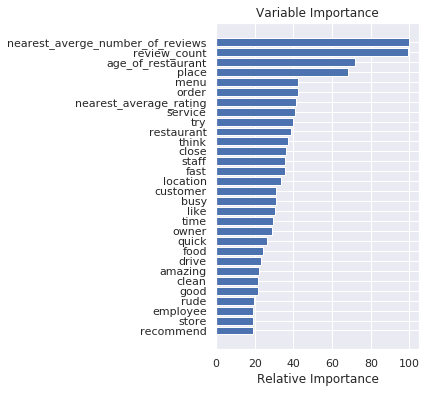

In [214]:
feature_importance = lgbm_model.feature_importance()
# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
# argsort sorts from smallest to largest
sorted_idx = np.argsort(feature_importance)[-30:]
pos = np.arange(sorted_idx.shape[0]) + .9
# # use only one column of a 1 x 2 figure
plt.subplot(1, 2, 2)
# pos is the postion of the bars on the y axis
# feature_importance[sorted_idx] is the width of the bars
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(all_the_features)[[sorted_idx]])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()
# print("\nColumn headers\n\n",X.columns)
# print("\n Feature Importance", feature_importance)
# print("\nargsorted from smallest to largest\n\n",sorted_idx)
# print("\nColumn headers\n\n",X.columns[sorted_idx])
# print("\nRearranged accordingly\n\n",feature_importance[sorted_idx])
# print("\nPosition on the y axis\n\n", pos)

#### XGBoost

In [216]:
from xgboost import XGBClassifier
xgboost_model = XGBClassifier()
xgboost_model.fit(X_train_bow_t, y_train_bow)
y_pred = xgboost_model.predict(X_test_bow_t)
y_pred_train = xgboost_model.predict(X_train_bow_t)
print('\n Confusion Matrix')
print(pd.crosstab(y_test_bow, y_pred, rownames=['True'], colnames=['Predicted']))
print(classification_report(y_test_bow, y_pred))
print("ROC-AUC", roc_auc_score(y_test_bow, y_pred))
print("PR-AUC-Score", average_precision_score(y_test_bow, y_pred))
print("Accuracy: ", accuracy_score(y_test_bow, y_pred))
print("Train Accuracy: ", accuracy_score(y_train_bow, y_pred_train))


 Confusion Matrix
Predicted   0.0   1.0
True                 
0.0        1796   683
1.0         730  1749
              precision    recall  f1-score   support

         0.0       0.71      0.72      0.72      2479
         1.0       0.72      0.71      0.71      2479

   micro avg       0.72      0.72      0.72      4958
   macro avg       0.72      0.72      0.71      4958
weighted avg       0.72      0.72      0.71      4958

ROC-AUC 0.7150060508269462
PR-AUC-Score 0.6546240061251354
Accuracy:  0.7150060508269463
Train Accuracy:  0.7974077062739561


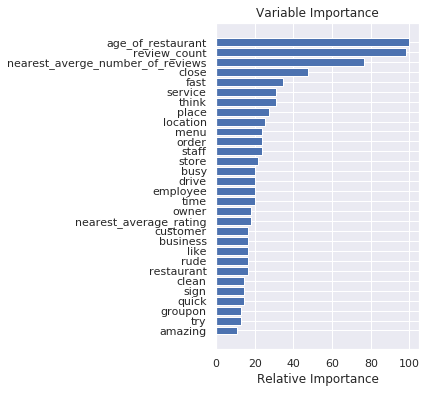

In [217]:
feature_importance = xgboost_model.feature_importances_
# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
# argsort sorts from smallest to largest
sorted_idx = np.argsort(feature_importance)[-30:]
pos = np.arange(sorted_idx.shape[0]) + .9
# # use only one column of a 1 x 2 figure
plt.subplot(1, 2, 2)
# pos is the postion of the bars on the y axis
# feature_importance[sorted_idx] is the width of the bars
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(all_the_features)[[sorted_idx]])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

### C. Bag of Words with IDF Penalty

#### Random Forest

In [218]:
from sklearn.ensemble import RandomForestClassifier
rfc_model = RandomForestClassifier(max_depth=50, n_estimators=900,  min_samples_leaf=15, n_jobs=-1)
rfc_model.fit(X_train_bow_penalized_t, y_train_bow)
y_pred = rfc_model.predict(X_test_bow_t)
y_pred_train = rfc_model.predict(X_train_bow_penalized_t)
print('\n Confusion Matrix')
print(pd.crosstab(y_test_bow, y_pred, rownames=['True'], colnames=['Predicted']))
print(classification_report(y_test_bow, y_pred))
print("ROC-AUC", roc_auc_score(y_test_bow, y_pred))
print("PR-AUC-Score", average_precision_score(y_test_bow, y_pred))
print("Test Accuracy: ", accuracy_score(y_test_bow, y_pred))
print("Train Accuracy: ", accuracy_score(y_train_bow, y_pred_train))


 Confusion Matrix
Predicted   0.0   1.0
True                 
0.0        2071   408
1.0        1293  1186
              precision    recall  f1-score   support

         0.0       0.62      0.84      0.71      2479
         1.0       0.74      0.48      0.58      2479

   micro avg       0.66      0.66      0.66      4958
   macro avg       0.68      0.66      0.65      4958
weighted avg       0.68      0.66      0.65      4958

ROC-AUC 0.6569181121419927
PR-AUC-Score 0.6167533757844438
Test Accuracy:  0.6569181121419927
Train Accuracy:  0.9032176719790196


#### LightGBM

In [220]:
import lightgbm as lgb 
lgb_train_data = lgb.Dataset(X_train_bow_penalized_t,label=y_train_bow)

params = {}
params['learning_rate'] = 0.003
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_error'
params['sub_feature'] = 0.5
params['num_leaves'] = 150
params['min_data'] = 50
params['max_depth'] = 30

#training our model using light gbm
num_round=1000
lgbm_model = lgb.train(params, lgb_train_data, num_round)

y_pred = lgbm_model.predict(X_test_bow_t)
#converting probabilities into 0 or 1
for i in range(0, len(y_test_bow)):
    if y_pred[i] >= .5:
        y_pred [i] = 1
    else:  
        y_pred [i] = 0
        
y_pred_train = lgbm_model.predict(X_train_bow_penalized_t)
#converting probabilities into 0 or 1
for i in range(0,len(y_train_bow)):
    if y_pred_train[i] >= .5:
        y_pred_train [i] = 1
    else:  
        y_pred_train [i] = 0
print('\n Confusion Matrix')
print(pd.crosstab(y_test_bow, y_pred, rownames=['True'], colnames=['Predicted']))
print(classification_report(y_test_bow, y_pred))
print("ROC-AUC", roc_auc_score(y_test_bow, y_pred))
print("PR-AUC-Score", average_precision_score(y_test_bow, y_pred))
print("Test Accuracy: ", accuracy_score(y_test_bow, y_pred))
print("Train Accuracy: ", accuracy_score(y_train_bow, y_pred_train))

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')



 Confusion Matrix
Predicted   0.0   1.0
True                 
0.0        1957   522
1.0         997  1482
              precision    recall  f1-score   support

         0.0       0.66      0.79      0.72      2479
         1.0       0.74      0.60      0.66      2479

   micro avg       0.69      0.69      0.69      4958
   macro avg       0.70      0.69      0.69      4958
weighted avg       0.70      0.69      0.69      4958

ROC-AUC 0.6936264622831787
PR-AUC-Score 0.6431908268980393
Test Accuracy:  0.6936264622831787
Train Accuracy:  0.9315614282832358


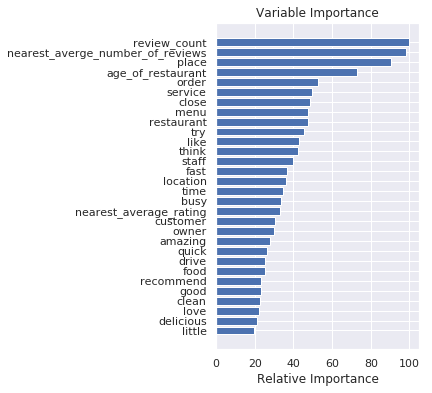

In [221]:
feature_importance = lgbm_model.feature_importance()
# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
# argsort sorts from smallest to largest
sorted_idx = np.argsort(feature_importance)[-30:]
pos = np.arange(sorted_idx.shape[0]) + .9
# # use only one column of a 1 x 2 figure
plt.subplot(1, 2, 2)
# pos is the postion of the bars on the y axis
# feature_importance[sorted_idx] is the width of the bars
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(all_the_features)[[sorted_idx]])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()
# print("\nColumn headers\n\n",X.columns)
# print("\n Feature Importance", feature_importance)
# print("\nargsorted from smallest to largest\n\n",sorted_idx)
# print("\nColumn headers\n\n",X.columns[sorted_idx])
# print("\nRearranged accordingly\n\n",feature_importance[sorted_idx])
# print("\nPosition on the y axis\n\n", pos)

average stars is not selected as important feature. All the other dense features are selected. Nearest average rating is the least important one.

place, order, service, close, menu, restaurant, try, like think, staff, fast are important textual features

#### XGBoost

In [224]:
from xgboost import XGBClassifier
xgboost_model = XGBClassifier()
xgboost_model.fit(X_train_bow_penalized_t, y_train_bow)
y_pred = xgboost_model.predict(X_test_bow_t)
y_pred_train = xgboost_model.predict(X_train_bow_penalized_t)
print('\n Confusion Matrix')
print(pd.crosstab(y_test_bow, y_pred, rownames=['True'], colnames=['Predicted']))
print(classification_report(y_test_bow, y_pred))
print("ROC-AUC", roc_auc_score(y_test_bow, y_pred))
print("PR-AUC-Score", average_precision_score(y_test_bow, y_pred))
print("Accuracy: ", accuracy_score(y_test_bow, y_pred))
print("Train Accuracy: ", accuracy_score(y_train_bow, y_pred_train))


 Confusion Matrix
Predicted   0.0   1.0
True                 
0.0        1833   646
1.0         887  1592
              precision    recall  f1-score   support

         0.0       0.67      0.74      0.71      2479
         1.0       0.71      0.64      0.68      2479

   micro avg       0.69      0.69      0.69      4958
   macro avg       0.69      0.69      0.69      4958
weighted avg       0.69      0.69      0.69      4958

ROC-AUC 0.690802743041549
PR-AUC-Score 0.6357274204299133
Accuracy:  0.690802743041549
Train Accuracy:  0.8365947145450877


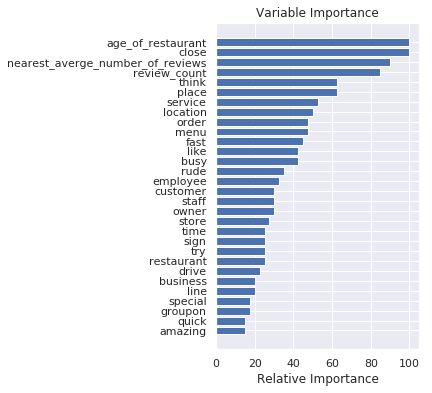

In [225]:
feature_importance = xgboost_model.feature_importances_
# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
# argsort sorts from smallest to largest
sorted_idx = np.argsort(feature_importance)[-30:]
pos = np.arange(sorted_idx.shape[0]) + .9
# # use only one column of a 1 x 2 figure
plt.subplot(1, 2, 2)
# pos is the postion of the bars on the y axis
# feature_importance[sorted_idx] is the width of the bars
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(all_the_features)[[sorted_idx]])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

XGBoost didn't select nearest average rating, average stars, as an important feature. 

think, place, service, location, order, menu, fast, like busy, rude are important textual features


IDF penality didn't increase the performance. Therefore I will only tune models using the bag of words model

## 4. Parameter Tuning and Testing

### Best Parameters for Logistic Regression

The training set is used for cross-validation. I gave it X_train_bow[:, 1:] which is the data that didn't pass through the pipeline. GridSearchCV divides the data into five and transforms the training folds and testing fold seprately. It ensures 0% data leakage.

In [228]:
pipeline = Pipeline([
                     ('dtf', DistanceTransformer()),
                     ('imputer', SimpleImputer(strategy="mean")), 
                     ("scale-normalize", CustomNormalizer()),
    ("logistic", LogisticRegression())])

In [239]:
from sklearn.model_selection import ParameterGrid, GridSearchCV
param_grid = {'logistic__C': [0.1, 0.15, 0.2, 0.25, 0.5, 0.8, 1.0, 1.25,1.5], 
                   'logistic__penalty' :['l2']
                  }
logistic_search = GridSearchCV(pipeline, param_grid, iid=False, cv=5,
                      return_train_score=True, n_jobs=-1)
logistic_search.fit(X_train_bow[:, 1:], y_train_bow)
print("Best parameter (CV score=%0.3f):" % logistic_search.best_score_)
print(logistic_search.best_params_)

Best parameter (CV score=0.845):
{'logistic__C': 1.5, 'logistic__penalty': 'l2'}


In [242]:
logistic_search.cv_results_

{'mean_fit_time': array([73.5935308 , 73.98362007, 74.47313714, 73.81953764, 73.86055508,
        72.70619111, 72.27944546, 72.20310106, 57.15355263]),
 'std_fit_time': array([0.26433671, 0.68433579, 0.19868645, 0.48705329, 0.64096314,
        0.25610647, 0.80351607, 0.45542303, 3.42984053]),
 'mean_score_time': array([11.89971633, 11.81096492, 11.83928585, 11.83185682, 11.88933687,
        11.65680456, 11.77552938, 11.75315151,  9.29918165]),
 'std_score_time': array([0.08561109, 0.06568171, 0.05616433, 0.08500734, 0.1434633 ,
        0.03662108, 0.15811555, 0.10930451, 1.51833826]),
 'param_logistic__C': masked_array(data=[0.1, 0.15, 0.2, 0.25, 0.5, 0.8, 1.0, 1.25, 1.5],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_logistic__penalty': masked_array(data=['l2', 'l2', 'l2', 'l2', 'l2', 'l2', 'l2', 'l2', 'l2'],
              mask=[False, False, False, False, False, False

In [275]:
y_pred = logistic_search.predict(X_test_bow[:,1:])
y_pred_train = logistic_search.predict(X_train_bow[:,1:])
print('\n Confusion Matrix')
print(pd.crosstab(y_test_bow, y_pred, rownames=['True'], colnames=['Predicted']))
print(classification_report(y_test_bow, y_pred))
print("ROC-AUC", roc_auc_score(y_test_bow, y_pred))
print("PR-AUC-Score", average_precision_score(y_test_bow, y_pred))
print("Test Accuracy: ", accuracy_score(y_test_bow, y_pred))
print("Train Accuracy: ", accuracy_score(y_train_bow, y_pred_train))


 Confusion Matrix
Predicted   0.0   1.0
True                 
0.0        1870   609
1.0         695  1784
              precision    recall  f1-score   support

         0.0       0.73      0.75      0.74      2479
         1.0       0.75      0.72      0.73      2479

   micro avg       0.74      0.74      0.74      4958
   macro avg       0.74      0.74      0.74      4958
weighted avg       0.74      0.74      0.74      4958

ROC-AUC 0.7369907220653489
PR-AUC-Score 0.6766784154469629
Test Accuracy:  0.7369907220653489
Train Accuracy:  0.900040346984063


Logistic Regression cross validation score shows 84% accuracy. There is very small varaince in cross validation test scores. It is promising result. The test-score is not more than 74%. 

### Best Parameters for LightGBM

In [ ]:
# This code takes 4 hours, it results are pasted below

# #https://lightgbm.readthedocs.io/en/latest/Parameters.html
# import lightgbm as lgb
# lgbm_classifier = lgb.LGBMClassifier(silent=False, n_jobs=20)

# # Create parameters to search
# gridParams = {}
# gridParams['lgbm_classifier__metric'] = ['binary_error']
# gridParams['lgbm_classifier__objective'] = ['binary']
# gridParams['lgbm_classifier__max_bin'] = [300]

# # the following parameters prevent overfitting
# gridParams['lgbm_classifier__num_leaves'] = [150]
# gridParams['lgbm_classifier__min_data_in_leaf'] = [50, 100]
# #gridParams['lgbm_classifier__min_sum_hessian_in_leaf']
# gridParams['lgbm_classifier__bagging_fraction'] =[0.8]
# gridParams['lgbm_classifier__bagging_freq'] = [5,10]
# gridParams['lgbm_classifier__feature_fraction'] = [0.7, 0.8]

# gridParams['lgbm_classifier__learning_rate'] = [0.01]
# gridParams['lgbm_classifier__n_estimators'] = [100]
# gridParams['lgbm_classifier__max_depth'] = [30]
# gridParams['lgbm_classifier__boosting_type'] = ['gbdt']
# gridParams['lgbm_classifier__subsample'] = [0.7, 0.75, 0.80]
# gridParams['lgbm_classifier__reg_alpha'] = [1.2]
# gridParams['lgbm_classifier__reg_lambda'] = [1.2]

# pipeline = Pipeline([('DFC', DistanceFeaturesCreator()),('imputer', SimpleImputer(strategy="mean")), 
#                      ("scale-normalize", CustomNormalizer()),("lgbm_classifier", lgbm_classifier)])
# # Create the grid
# grid = GridSearchCV(pipeline, gridParams, verbose=1, cv=3, n_jobs=-1)

# lgb_train_data2 =lgb.Dataset(X_train_rt,label=y_train_resampled)

# grid.fit(X_train_rt, y_train_resampled)

# # Print the best parameters found
# print(grid.best_params_)
# print(grid.best_score_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 74.3min

[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 117.0min finished

{'lgbm_classifier__bagging_fraction': 0.8, 'lgbm_classifier__bagging_freq': 10, 'lgbm_classifier__boosting_type': 'gbdt', 'lgbm_classifier__feature_fraction': 0.7, 'lgbm_classifier__learning_rate': 0.01, 'lgbm_classifier__max_bin': 300, 'lgbm_classifier__max_depth': 30, 'lgbm_classifier__metric': 'binary_error', 'lgbm_classifier__min_data_in_leaf': 50, 'lgbm_classifier__n_estimators': 100, 'lgbm_classifier__num_leaves': 150, 'lgbm_classifier__objective': 'binary', 'lgbm_classifier__reg_alpha': 1.2, 'lgbm_classifier__reg_lambda': 1.2, 'lgbm_classifier__subsample': 0.7}

0.7127799072019366

In [ ]:
# this code took 8 hours, it results are pasted below

# #https://lightgbm.readthedocs.io/en/latest/Parameters.html
# import lightgbm as lgb
# lgbm_classifier = lgb.LGBMClassifier(silent=False, n_jobs=20)

# # Create parameters to search
# gridParams = {}
# gridParams['lgbm_classifier__metric'] = ['binary_error']
# gridParams['lgbm_classifier__objective'] = ['binary']
# gridParams['lgbm_classifier__max_bin'] = [300]

# # the following parameters prevent overfitting
# gridParams['lgbm_classifier__num_leaves'] = [100,150]
# gridParams['lgbm_classifier__min_data_in_leaf'] = [40, 50]
# #gridParams['lgbm_classifier__min_sum_hessian_in_leaf']
# gridParams['lgbm_classifier__bagging_fraction'] =[0.7]
# gridParams['lgbm_classifier__bagging_freq'] = [10]
# gridParams['lgbm_classifier__feature_fraction'] = [0.6, 0.7, 0.8]

# gridParams['lgbm_classifier__learning_rate'] = [0.01]
# gridParams['lgbm_classifier__n_estimators'] = [100]
# gridParams['lgbm_classifier__max_depth'] = [20,30]
# gridParams['lgbm_classifier__boosting_type'] = ['gbdt']
# gridParams['lgbm_classifier__subsample'] = [0.6, 0.7]
# gridParams['lgbm_classifier__reg_alpha'] = [1.2]
# gridParams['lgbm_classifier__reg_lambda'] = [1.2]

# pipeline = Pipeline([('DFC', DistanceFeaturesCreator()),('imputer', SimpleImputer(strategy="mean")), 
#                      ("scale-normalize", CustomNormalizer()),("lgbm_classifier", lgbm_classifier)])
# # Create the grid
# grid = GridSearchCV(pipeline, gridParams, verbose=1, cv=3, n_jobs=-1)

# lgb_train_data2 =lgb.Dataset(X_train_rt,label=y_train_resampled)

# grid.fit(X_train_rt, y_train_resampled)

# # Print the best parameters found
# print(grid.best_params_)
# print(grid.best_score_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
    
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 57.8min
        
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 188.7min finished
        
{'lgbm_classifier__bagging_fraction': 0.7, 'lgbm_classifier__bagging_freq': 10, 'lgbm_classifier__boosting_type': 'gbdt', 'lgbm_classifier__feature_fraction': 0.6, 'lgbm_classifier__learning_rate': 0.01, 'lgbm_classifier__max_bin': 300, 'lgbm_classifier__max_depth': 20, 'lgbm_classifier__metric': 'binary_error', 'lgbm_classifier__min_data_in_leaf': 50, 'lgbm_classifier__n_estimators': 100, 'lgbm_classifier__num_leaves': 100, 'lgbm_classifier__objective': 'binary', 'lgbm_classifier__reg_alpha': 1.2, 'lgbm_classifier__reg_lambda': 1.2, 'lgbm_classifier__subsample': 0.6}

0.715856364736736

In [ ]:
# This code took more than 8 hours. Its results are pasted below

# #https://lightgbm.readthedocs.io/en/latest/Parameters.html
# import lightgbm as lgb
# lgbm_classifier = lgb.LGBMClassifier(silent=False, n_jobs=20)

# # Create parameters to search
# gridParams = {}
# gridParams['lgbm_classifier__metric'] = ['binary_error']
# gridParams['lgbm_classifier__objective'] = ['binary']
# gridParams['lgbm_classifier__max_bin'] = [300]

# # the following parameters prevent overfitting
# gridParams['lgbm_classifier__num_leaves'] = [100,150]
# gridParams['lgbm_classifier__min_data_in_leaf'] = [60, 70]
# #gridParams['lgbm_classifier__min_sum_hessian_in_leaf']
# gridParams['lgbm_classifier__bagging_fraction'] =[0.6, 0.65]
# gridParams['lgbm_classifier__bagging_freq'] = [10]
# gridParams['lgbm_classifier__feature_fraction'] = [0.5, 0.6, 0.7]

# gridParams['lgbm_classifier__learning_rate'] = [0.01]
# gridParams['lgbm_classifier__n_estimators'] = [100]
# gridParams['lgbm_classifier__max_depth'] = [20, 25]
# gridParams['lgbm_classifier__boosting_type'] = ['gbdt']
# gridParams['lgbm_classifier__subsample'] = [0.6, 0.65]
# gridParams['lgbm_classifier__reg_alpha'] = [1.2]
# gridParams['lgbm_classifier__reg_lambda'] = [1.2]

# pipeline = Pipeline([('DFC', DistanceFeaturesCreator()),('imputer', SimpleImputer(strategy="mean")), 
#                      ("scale-normalize", CustomNormalizer()),("lgbm_classifier", lgbm_classifier)])
# # Create the grid
# grid = GridSearchCV(pipeline, gridParams, verbose=1, cv=3, n_jobs=-1)

# lgb_train_data2 =lgb.Dataset(X_train_rt,label=y_train_resampled)

# grid.fit(X_train_rt, y_train_resampled)

# # Print the best parameters found
# print(grid.best_params_)
# print(grid.best_score_)

Fitting 3 folds for each of 96 candidates, totalling 288 fits

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
    
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 51.4min
        
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 266.8min
        
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed: 396.1min finished
        
{'lgbm_classifier__bagging_fraction': 0.65, 'lgbm_classifier__bagging_freq': 10, 'lgbm_classifier__boosting_type': 'gbdt', 'lgbm_classifier__feature_fraction': 0.5, 'lgbm_classifier__learning_rate': 0.01, 'lgbm_classifier__max_bin': 300, 'lgbm_classifier__max_depth': 20, 'lgbm_classifier__metric': 'binary_error', 'lgbm_classifier__min_data_in_leaf': 60, 'lgbm_classifier__n_estimators': 100, 'lgbm_classifier__num_leaves': 100, 'lgbm_classifier__objective': 'binary', 'lgbm_classifier__reg_alpha': 1.2, 'lgbm_classifier__reg_lambda': 1.2, 'lgbm_classifier__subsample': 0.6}

0.7143937865644543

In [277]:
import lightgbm as lgb 
lgb_train_data =lgb.Dataset(X_train_bow_t,label=y_train_bow)

params = {}

params['bagging_fraction'] = 0.7
params['bagging_freq'] = 10
params['boosting_type'] = 'gbdt'
params['feature_fraction'] = 0.6
params['learning_rate'] = 0.01
params['max_bin'] = 300
params['max_depth'] = 20
    
params['metric'] = 'binary_error'
params['min_data_in_leaf'] = 50 
params['n_estimators'] = 100 
params['num_leaves'] = 100
params['objective'] = 'binary'
params['reg_alpha'] = 1.2, 
params['reg_lambda'] = 1.2
params['subsample'] = 0.6

num_round=100
lgbm_model_final=lgb.train(params, lgb_train_data, num_round)

y_pred = lgbm_model_final.predict(X_test_bow_t)
#converting probabilities into 0 or 1
for i in range(0,len(y_test_bow)):
    if y_pred[i] >= .5:
        y_pred [i] = 1
    else:  
        y_pred [i] = 0
        
y_pred_train = lgbm_model_final.predict(X_train_bow_t)
#converting probabilities into 0 or 1
for i in range(0,len(y_train_bow)):
    if y_pred_train[i] >= .5:
        y_pred_train [i] = 1
    else:  
        y_pred_train [i] = 0
print('\n Confusion Matrix')
print(pd.crosstab(y_test_bow, y_pred, rownames=['True'], colnames=['Predicted']))
print(classification_report(y_test_bow, y_pred))
print("ROC-AUC", roc_auc_score(y_test_bow, y_pred))
print("PR-AUC-Score", average_precision_score(y_test_bow, y_pred))
print("Test Accuracy: ", accuracy_score(y_test_bow, y_pred))
print("Train Accuracy: ", accuracy_score(y_train_bow, y_pred_train))

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')



 Confusion Matrix
Predicted   0.0   1.0
True                 
0.0        1957   522
1.0         986  1493
              precision    recall  f1-score   support

         0.0       0.66      0.79      0.72      2479
         1.0       0.74      0.60      0.66      2479

   micro avg       0.70      0.70      0.70      4958
   macro avg       0.70      0.70      0.69      4958
weighted avg       0.70      0.70      0.69      4958

ROC-AUC 0.6958450988301735
PR-AUC-Score 0.6451100409694536
Test Accuracy:  0.6958450988301734
Train Accuracy:  0.821111559410934


In [278]:
import lightgbm as lgb 
lgb_train_data =lgb.Dataset(X_train_bow_t,label=y_train_bow)

params = {}

params['bagging_fraction'] = 0.65
params['bagging_freq'] = 10
params['boosting_type'] = 'gbdt'
params['feature_fraction'] = 0.5
params['learning_rate'] = 0.01
params['max_bin'] = 300
params['max_depth'] = 20
    
params['metric'] = 'binary_error'
params['min_data_in_leaf'] = 60
params['n_estimators'] = 100 
params['num_leaves'] = 100
params['objective'] = 'binary'
params['reg_alpha'] = 1.2, 
params['reg_lambda'] = 1.2
params['subsample'] = 0.6

num_round=100
lgbm_model_final=lgb.train(params, lgb_train_data, num_round)

y_pred = lgbm_model_final.predict(X_test_bow_t)
#converting probabilities into 0 or 1
for i in range(0,len(y_test_bow)):
    if y_pred[i] >= .5:
        y_pred [i] = 1
    else:  
        y_pred [i] = 0
        
y_pred_train = lgbm_model_final.predict(X_train_bow_t)
#converting probabilities into 0 or 1
for i in range(0,len(y_train_bow)):
    if y_pred_train[i] >= .5:
        y_pred_train [i] = 1
    else:  
        y_pred_train [i] = 0
print('\n Confusion Matrix')
print(pd.crosstab(y_test_bow, y_pred, rownames=['True'], colnames=['Predicted']))
print(classification_report(y_test_bow, y_pred))
print("ROC-AUC", roc_auc_score(y_test_bow, y_pred))
print("PR-AUC-Score", average_precision_score(y_test_bow, y_pred))
print("Test Accuracy: ", accuracy_score(y_test_bow, y_pred))
print("Train Accuracy: ", accuracy_score(y_train_bow, y_pred_train))

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:478: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')



 Confusion Matrix
Predicted   0.0   1.0
True                 
0.0        1943   536
1.0         954  1525
              precision    recall  f1-score   support

         0.0       0.67      0.78      0.72      2479
         1.0       0.74      0.62      0.67      2479

   micro avg       0.70      0.70      0.70      4958
   macro avg       0.71      0.70      0.70      4958
weighted avg       0.71      0.70      0.70      4958

ROC-AUC 0.6994755949979831
PR-AUC-Score 0.6475983902823503
Test Accuracy:  0.6994755949979831
Train Accuracy:  0.8228767399636877


### Feature Importances for final lightgbm model

In [ ]:
feature_importance = lgbm_model_final.feature_importance()
# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
# argsort sorts from smallest to largest
sorted_idx = np.argsort(feature_importance)[-30:]
pos = np.arange(sorted_idx.shape[0]) + .9
# # use only one column of a 1 x 2 figure
sns.set(rc={'figure.figsize':(12,10)})

plt.subplot(1, 2, 2)
# pos is the postion of the bars on the y axis
# feature_importance[sorted_idx] is the width of the bars
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(all_the_features)[[sorted_idx]])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

## 5. Separating Bag of Words and Dense Features

### Only Bag of Words

#### Logistic Regression

In [310]:
logistic_model = LogisticRegression(penalty='l2', C=1.0)
logistic_model.fit(X_train_bow[:,6:], y_train_bow)
y_pred = logistic_model.predict(X_test_bow[:,6:])
y_pred_train = logistic_model.predict(X_train_bow[:,6:])
print('\n Confusion Matrix')
print(pd.crosstab(y_test_bow, y_pred, rownames=['True'], colnames=['Predicted']))
print(classification_report(y_test_bow, y_pred))
print("ROC-AUC", roc_auc_score(y_test_bow, y_pred))
print("PR-AUC-Score", average_precision_score(y_test_bow, y_pred))
print("Test Accuracy: ", accuracy_score(y_test_bow, y_pred))
print("Train Accuracy: ", accuracy_score(y_train_bow, y_pred_train))


 Confusion Matrix
Predicted   0.0  1.0
True                
0.0        2448   31
1.0        2267  212
              precision    recall  f1-score   support

         0.0       0.52      0.99      0.68      2479
         1.0       0.87      0.09      0.16      2479

   micro avg       0.54      0.54      0.54      4958
   macro avg       0.70      0.54      0.42      4958
weighted avg       0.70      0.54      0.42      4958

ROC-AUC 0.536506655909641
PR-AUC-Score 0.5318494282010037
Test Accuracy:  0.536506655909641
Train Accuracy:  0.9140609239459351


In [313]:
only_bow = restaurants_vectorizer_bow2.get_feature_names()
print("Most positive cofficeints\n(contribute positively to restaurants closure)")
print()
sorted_features = np.argsort(logistic_model.coef_).ravel()[::-1]
for i in range(15):
    print(only_bow[sorted_features[i]], end=",")
print()
print("\nMost negative cofficeints\n(contribute negatively to restaurants closure)")
print()
sorted_features = np.argsort(logistic_model.coef_).ravel()
for i in range(15):
    print(only_bow[sorted_features[i]],end=",")
print("\n\nThe Coefficients\n")
print(logistic_model.coef_.ravel()[:10])

Most positive cofficeints
(contribute positively to restaurants closure)

place,close,restaurant,think,try,menu,owner,like,vegas,sign,business,little,good,remember,friendly,

Most negative cofficeints
(contribute negatively to restaurants closure)

order,busy,come,staff,amazing,service,favorite,year,family,store,tho,parking,appreciate,super,fast,

The Coefficients

[ 0.13514072  0.29276576 -0.12545517 -0.27532779 -0.23897298 -0.41322727
  0.12759922  0.17847337  0.13156616  0.12195385]


When combined with dense features logistic regression was not showing the actual words which contributed to restaurants closure. These ones look better. Words like amazing, service, favorite are truly positive words.

According to this model, people say restaurant, close and place for a restaurant that will close. The words are not that much negative. Even some words like friendly are included. It may have been tokenized from not friendly/

#### XGBoost

In [318]:
from xgboost import XGBClassifier
xgboost_model = XGBClassifier()
xgboost_model.fit(X_train_bow[:,6:], y_train_bow)
y_pred = xgboost_model.predict(X_test_bow[:,6:])
y_pred_train = xgboost_model.predict(X_train_bow[:,6:])

print('\n Confusion Matrix')
print(pd.crosstab(y_test_bow, y_pred, rownames=['True'], colnames=['Predicted']))
print(classification_report(y_test_bow, y_pred))
print("ROC-AUC", roc_auc_score(y_test_bow, y_pred))
print("PR-AUC-Score", average_precision_score(y_test_bow, y_pred))
print("Test Accuracy: ", accuracy_score(y_test_bow, y_pred))


 Confusion Matrix
Predicted   0.0  1.0
True                
0.0        2095  384
1.0        1614  865
              precision    recall  f1-score   support

         0.0       0.56      0.85      0.68      2479
         1.0       0.69      0.35      0.46      2479

   micro avg       0.60      0.60      0.60      4958
   macro avg       0.63      0.60      0.57      4958
weighted avg       0.63      0.60      0.57      4958

ROC-AUC 0.5970149253731343
PR-AUC-Score 0.567188078821266
Test Accuracy:  0.5970149253731343


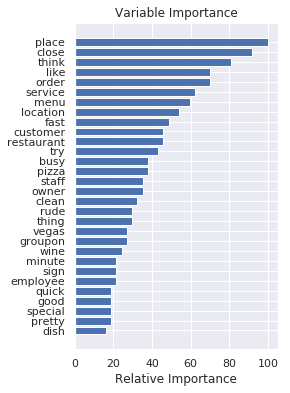

In [320]:
feature_importance = xgboost_model.feature_importances_
# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
# argsort sorts from smallest to largest
sorted_idx = np.argsort(feature_importance)[-30:]
pos = np.arange(sorted_idx.shape[0]) + .9
# # use only one column of a 1 x 2 figure
plt.subplot(1, 2, 2)
# pos is the postion of the bars on the y axis
# feature_importance[sorted_idx] is the width of the bars
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(only_bow)[[sorted_idx]])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

The words are similar to the onces obtained before. More research is required to know why these words are good predictors. 

### Only Dense Features

In [299]:
logistic_model = LogisticRegression(penalty='l2', C=1.0)
logistic_model.fit(X_train_bow_t.tocsr()[:,:5], y_train_bow)
y_pred = logistic_model.predict(X_test_bow_t.tocsr()[:,:5])
y_pred_train = logistic_model.predict(X_train_bow_t.tocsr()[:,:5])
print('\n Confusion Matrix')
print(pd.crosstab(y_test_bow, y_pred, rownames=['True'], colnames=['Predicted']))
print(classification_report(y_test_bow, y_pred))
print("ROC-AUC", roc_auc_score(y_test_bow, y_pred))
print("PR-AUC-Score", average_precision_score(y_test_bow, y_pred))
print("Test Accuracy: ", accuracy_score(y_test_bow, y_pred))
print("Train Accuracy: ", accuracy_score(y_train_bow, y_pred_train))


 Confusion Matrix
Predicted   0.0   1.0
True                 
0.0        1564   915
1.0         886  1593
              precision    recall  f1-score   support

         0.0       0.64      0.63      0.63      2479
         1.0       0.64      0.64      0.64      2479

   micro avg       0.64      0.64      0.64      4958
   macro avg       0.64      0.64      0.64      4958
weighted avg       0.64      0.64      0.64      4958

ROC-AUC 0.636748688987495
PR-AUC-Score 0.586858318005215
Test Accuracy:  0.6367486889874949
Train Accuracy:  0.6555880572927174


In [309]:
print("Most positive cofficeints\n(contribute positively to restaurants closure)")
print()
sorted_features = np.argsort(logistic_model.coef_).ravel()[::-1]
for i in range(5):
    print(first_5[sorted_features[i]], end=",")
print()
print("\nMost negative cofficeints\n(contribute negatively to restaurants closure)")
print()
sorted_features = np.argsort(logistic_model.coef_).ravel()
for i in range(5):
    print(first_5[sorted_features[i]],end=",")
print("\n\nThe Coefficients\n")
print(first_5)
print(logistic_model.coef_.ravel())

Most positive cofficeints
(contribute positively to restaurants closure)

age_of_restaurant,nearest_averge_number_of_reviews,average_stars,nearest_average_rating,review_count,

Most negative cofficeints
(contribute negatively to restaurants closure)

review_count,nearest_average_rating,average_stars,nearest_averge_number_of_reviews,age_of_restaurant,

The Coefficients

['nearest_average_rating', 'nearest_averge_number_of_reviews', 'average_stars', 'review_count', 'age_of_restaurant']
[ 0.04853778  0.50964896  0.15131915 -0.79238542  0.524393  ]


The age of a restaurant contributes the most to restaurant closure. It is interesting to see that the nereast average number of reviews contribute to closure while more reviews helps a restaurant to survive

In [315]:
from xgboost import XGBClassifier

xgboost_model = XGBClassifier()
xgboost_model.fit(X_train_bow_t.tocsr()[:,:5], y_train_bow)
y_pred = xgboost_model.predict(X_test_bow_t.tocsr()[:,:5])
y_pred_train = xgboost_model.predict(X_train_bow_t.tocsr()[:,:5])

print('\n Confusion Matrix')
print(pd.crosstab(y_test_bow, y_pred, rownames=['True'], colnames=['Predicted']))
print(classification_report(y_test_bow, y_pred))
print("ROC-AUC", roc_auc_score(y_test_bow, y_pred))
print("PR-AUC-Score", average_precision_score(y_test_bow, y_pred))
print("Test Accuracy: ", accuracy_score(y_test_bow, y_pred))


 Confusion Matrix
Predicted   0.0   1.0
True                 
0.0        1585   894
1.0         784  1695
              precision    recall  f1-score   support

         0.0       0.67      0.64      0.65      2479
         1.0       0.65      0.68      0.67      2479

   micro avg       0.66      0.66      0.66      4958
   macro avg       0.66      0.66      0.66      4958
weighted avg       0.66      0.66      0.66      4958

ROC-AUC 0.6615570794675273
PR-AUC-Score 0.6057702779827959
Test Accuracy:  0.6615570794675272


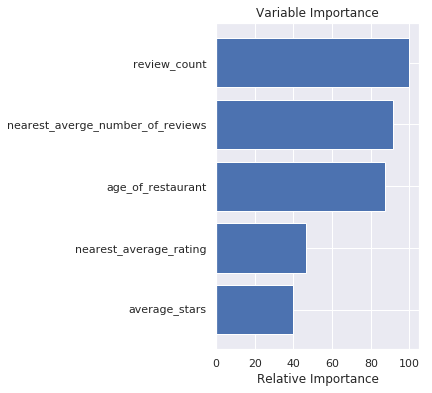

In [316]:
feature_importance = xgboost_model.feature_importances_
# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
# argsort sorts from smallest to largest
sorted_idx = np.argsort(feature_importance)[-30:]
pos = np.arange(sorted_idx.shape[0]) + .9
# # use only one column of a 1 x 2 figure
plt.subplot(1, 2, 2)
# pos is the postion of the bars on the y axis
# feature_importance[sorted_idx] is the width of the bars
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(all_the_features)[[sorted_idx]])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

The dense features are better predictors of restaurants closure. They achieve around 63% accuracy on the testset. Bag of words model achieves around 53% accuracy. When the two are combined the accuracy goes up to 75% on the test-set. Logistic regression achieved 84% corss validation score with very small variance accross folds.

### Health Inspection Data

Health inspection results seem highly predictive of restaurants closure. I tried to obtain data about the 11 meteropolitan areas that are used for this project. Most of those areas or cities don't have complete data. Southern nevada has complete data but only 1000 restaurants match the Yelp dataset. I used more than 30000 restaurants in this project. Thus integrating health inspection data is not possible. I can do a seprate project on those 1000 restaurants.

In [322]:
# restaurant_inspection = pd.read_csv("../../../Data & Script/nevada_restaurant_inspection.csv").drop(["State", "Serial Number", "Employee ID", "Permit Number", "Inspection Time"], axis=1)

In [323]:
# restaurant_inspection.head(3)

In [324]:
# restaurant_inspection.columns